# Training Using RobustScalat for Normalization


### Library Import & Initial Setup

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from math import sqrt, atan2
from scipy.signal import savgol_filter
from hampel import hampel
from sklearn.preprocessing import RobustScaler
from collections import defaultdict


### Load DataSet CIS Raw

In [2]:
# Path ke dataset RX_1
main_folder_path_rx1 = os.path.join('old_dataset', 'dataset RX 1 Lama')

# Inisialisasi struktur data untuk menyimpan hasil
activity_dataframes_rx1 = []
label_list_rx1 = []
label_row_counts_rx1 = defaultdict(int)

# Iterasi melalui setiap subfolder dalam RX_1
for activity_folder in os.listdir(main_folder_path_rx1):
    activity_folder_path = os.path.join(main_folder_path_rx1, activity_folder)
    
    if os.path.isdir(activity_folder_path):  # Pastikan ini folder
        for file_name in os.listdir(activity_folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(activity_folder_path, file_name)
                
                # Tambahkan label aktivitas
                label_list_rx1.append(activity_folder)
                
                # Baca file CSV ke DataFrame
                df = pd.read_csv(file_path)
                activity_dataframes_rx1.append(df)

                # Hitung jumlah baris per label
                label_row_counts_rx1[activity_folder] += len(df)

print("Data RX_1 lama telah dimuat.")

Data RX_1 lama telah dimuat.


In [3]:
type(activity_dataframes_rx1)

list

In [4]:
# Path ke dataset RX_2
main_folder_path_rx2 = os.path.join('old_dataset', 'dataset RX 2 Lama')

# Inisialisasi struktur data untuk menyimpan hasil
activity_dataframes_rx2 = []
label_list_rx2 = []
label_row_counts_rx2 = defaultdict(int)

# Iterasi melalui setiap subfolder dalam RX_2
for activity_folder in os.listdir(main_folder_path_rx2):
    activity_folder_path = os.path.join(main_folder_path_rx2, activity_folder)
    
    if os.path.isdir(activity_folder_path):  # Pastikan ini folder
        for file_name in os.listdir(activity_folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(activity_folder_path, file_name)
                
                # Tambahkan label aktivitas
                label_list_rx2.append(activity_folder)
                
                # Baca file CSV ke DataFrame
                df = pd.read_csv(file_path)
                activity_dataframes_rx2.append(df)

                # Hitung jumlah baris per label
                label_row_counts_rx2[activity_folder] += len(df)

print("Data RX_2 lama telah dimuat.")


Data RX_2 lama telah dimuat.


### Membuat fungsi untuk visualisasi

In [5]:
def plot_bar_chart(dd_counts, jl_counts, bd_counts):
    # Labels
    labels = ['dd', 'jl', 'bd']
    
    # Values
    dd_values = [dd_counts.get(str(i), 0) for i in range(3)]
    jl_values = [jl_counts.get(str(i), 0) for i in range(3)]
    bd_values = [bd_counts.get(str(i), 0) for i in range(3)]
    
    x = range(len(dd_values))
    width = 0.2

    fig, ax = plt.subplots()
    ax.bar([i - width for i in x], dd_values, width, label='DD')
    ax.bar(x, jl_values, width, label='JL')
    ax.bar([i + width for i in x], bd_values, width, label='BD')

    ax.set_ylabel('Jumlah Data')
    ax.set_title('Jumlah Data berdasarkan Label')
    ax.set_xticks(x)
    ax.set_xticklabels(['0', '1', '2'])
    ax.legend()

    plt.show()

In [6]:
def plot_data(df, numeric,max_cols):
    """
    Plots the numeric columns of the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame to plot
    numeric (list): List of numeric column names to plot
    """
    # max_cols = 20  # Set maximum columns to plot
    cols_to_plot = numeric[:max_cols]  # Take only the first 10 columns

    plt.figure(figsize=(35, 15))  # Adjusted figure size for better visualization
    for i, col in enumerate(cols_to_plot, 1):
        plt.subplot(len(cols_to_plot), 1, i)
        sns.boxplot(data=df, x=col)
        plt.title(f'Title: {col}')
    plt.tight_layout()
    plt.show()

In [7]:
def plot_boxplots(df,titel):
    """
    Plots boxplots for all numeric columns in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing numeric data to plot
    """
    plt.figure(figsize=(20, 10))  # Adjust figure size as needed

    all_data = []

    for col in df.columns:
        data = pd.to_numeric(df[col], errors='coerce').dropna().values
        all_data.append(data)

    plt.boxplot(all_data, labels=df.columns)
    plt.xlabel('Subcarier')
    plt.ylabel('Amplitude')
    # plt.title(titel)
    plt.xticks(rotation=45)  # Rotate x-axis labels if necessary for readability

    plt.show()

## Exploratory Data Analysis (EDA)

## total row

### RX1

In [8]:
total_rx1 = 0

# Menampilkan jumlah baris untuk setiap label di RX_1
print("Jumlah Dataset pada RX_1:")
for label, total_rows in label_row_counts_rx1.items():
    print(f'{label} : {total_rows} rows')
    total_rx1 += total_rows

print('Total :', total_rx1)


Jumlah Dataset pada RX_1:
BD : 43342 rows
DD : 38952 rows
JL : 39412 rows
Total : 121706


### RX2

In [9]:
total_rx2 = 0

# Menampilkan jumlah baris untuk setiap label di RX_2
print("Jumlah Dataset pada RX_2:")
for label, total_rows in label_row_counts_rx2.items():
    print(f'{label} : {total_rows} rows')
    total_rx2 += total_rows

print('Total :', total_rx2)


Jumlah Dataset pada RX_2:
BD : 35215 rows
DD : 29619 rows
JL : 30370 rows
Total : 95204


### RX1

In [10]:
activity_dataframes_rx1[0].describe()  # Menampilkan statistik deskriptif dari file pertama RX 1


,rssi,rate,sig_mode,mcs,bandwidth,smoothing,not_sounding,aggregation,stbc,fec_coding,...,ampdu_cnt,channel,secondary_channel,local_timestamp,ant,sig_len,rx_state,real_time_set,real_timestamp,len
count,2989.000000,2989.0,2989.000000,2989.000000,2989.000000,2989.000000,2989.000000,2989.000000,2989.0,2989.0,...,2989.000000,2989.0,2989.0,2.989000e+03,2989.0,2989.000000,2989.0,2989.0,2989.000000,2989.000000
mean,-70.321512,11.0,0.954165,2.895283,0.954165,0.954165,0.954165,0.072265,0.0,0.0,...,0.142188,6.0,1.0,7.465939e+07,0.0,109.955169,0.0,0.0,75.126124,372.266310
std,1.536485,0.0,0.209162,0.865489,0.209162,0.209162,0.209162,0.258969,0.0,0.0,...,0.695311,0.0,0.0,3.618232e+07,0.0,3.738436,0.0,0.0,36.206774,53.545349
min,-74.000000,11.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,6.0,1.0,4.260100e+04,0.0,30.000000,0.0,0.0,0.430911,128.000000
25%,-71.000000,11.0,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,...,0.000000,6.0,1.0,4.378618e+07,0.0,110.000000,0.0,0.0,44.237200,384.000000
50%,-71.000000,11.0,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,...,0.000000,6.0,1.0,7.480674e+07,0.0,110.000000,0.0,0.0,75.194800,384.000000
75%,-70.000000,11.0,1.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,...,0.000000,6.0,1.0,1.060029e+08,0.0,110.000000,0.0,0.0,106.445000,384.000000
max,-63.000000,11.0,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,...,6.000000,6.0,1.0,1.374255e+08,0.0,239.000000,0.0,0.0,138.003000,384.000000


### RX2

In [11]:
activity_dataframes_rx2[0].describe()  # Menampilkan statistik deskriptif dari file pertama RX 2


,rssi,rate,sig_mode,mcs,bandwidth,smoothing,not_sounding,aggregation,stbc,fec_coding,...,ampdu_cnt,channel,secondary_channel,local_timestamp,ant,sig_len,rx_state,real_time_set,real_timestamp,len
count,2330.000000,2330.0,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.0,2330.0,2330.0,...,2330.0,2330.0,2330.0,2.330000e+03,2330.0,2330.000000,2330.0,2330.0,2330.000000,2330.000000
mean,-78.929185,11.0,0.778541,0.176824,0.778541,0.778541,0.778541,0.0,0.0,0.0,...,0.0,6.0,1.0,7.508133e+07,0.0,109.942489,0.0,0.0,75.541564,327.306438
std,3.146578,0.0,0.415318,0.381602,0.415318,0.415318,0.415318,0.0,0.0,0.0,...,0.0,0.0,0.0,3.831359e+07,0.0,4.234349,0.0,0.0,38.317512,106.321416
min,-90.000000,11.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,6.0,1.0,4.252700e+04,0.0,30.000000,0.0,0.0,0.451157,128.000000
25%,-81.000000,11.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,...,0.0,6.0,1.0,4.094739e+07,0.0,110.000000,0.0,0.0,41.380500,384.000000
50%,-79.000000,11.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,...,0.0,6.0,1.0,7.572148e+07,0.0,110.000000,0.0,0.0,76.165050,384.000000
75%,-77.000000,11.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,...,0.0,6.0,1.0,1.106791e+08,0.0,110.000000,0.0,0.0,111.157750,384.000000
max,-70.000000,11.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,...,0.0,6.0,1.0,1.385096e+08,0.0,239.000000,0.0,0.0,138.918000,384.000000


## Extract amplitude from dataframes

In [12]:
# Loop melalui setiap dataframe dalam activity_dataframes_rx1
amp_dataframes_rx1 = []
for df_RX1 in activity_dataframes_rx1:
    data_RX1 = []
    for _, row_RX1 in df_RX1.iterrows():
        imaginary_RX1 = []
        real_RX1 = []
        amplitudes_RX1 = []

        csi_data = row_RX1['CSI_DATA']
        # Pastikan CSI_DATA adalah string sebelum diproses
        if isinstance(csi_data, str):
            # Parsing string menjadi daftar integer
            csi_matches = re.findall(r"\[(.*)\]", csi_data)
            if csi_matches:
                csi_string = csi_matches[0]
                csi_raw = [int(x) for x in csi_string.split(" ") if re.match(r"^-?\d+$", x)]



                # Pisahkan angka menjadi imaginary dan real
                for i in range(len(csi_raw)):
                    if i % 2 == 0:
                        imaginary_RX1.append(csi_raw[i])
                    else:
                        real_RX1.append(csi_raw[i])

                # Hitung amplitude
                for i in range(int(len(csi_raw) / 2)):
                    amplitudes_RX1.append(sqrt(imaginary_RX1[i] ** 2 + real_RX1[i] ** 2))
                
                data_RX1.append(amplitudes_RX1)
            else:
                print(f"Tidak ada kecocokan untuk baris: {csi_data}")
        else:
            print(f"Tipe data tidak valid untuk CSI_DATA: {type(csi_data)}")

    # Konversi data ke DataFrame dan tambahkan ke amp_dataframes_rx1
    temp_df_RX1 = pd.DataFrame(data_RX1)
    amp_dataframes_rx1.append(temp_df_RX1)

Tidak ada kecocokan untuk baris: [110 96 6 0 0 0 0 0 0 0 0 0 8 -4 7 -4 8 -3 8 -3 8 -4 8 -3 9 -2 9 -2 8 -3 9 -2 9 -3 9 -1 9 -1 9 -1 9 -2 9 -2 9 -2 9 -2 9 -1 10 -2 10 -2 10 -3 11 -1 11 -2 11 -2 10 -2 0 0 11 -2 11 -2 11 -3 13 -4 12 -2 12 -3 12 -2 13 -3 12 -1 13 -1 13 -3 13 -1 14 -3 13 -3 15 -4 14 -4 15 -4 14 -4 15 -4 14 -5 15 -3 15 -4 17 -4
Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tidak ada kecocokan untuk baris: [110 96 6 0 0 0 0 0 0 0 0 0 -7 9 -6 10 -8 10 -8 9 -8 9 -8 8 -8 7 -8 8 -9 8 -9 8 -9 8 -9 9 -9 8 -9 8 -8 7 -9 8 -9 7 -9 8 -10 8 -10 7 -9 8 -10 7 -10 7 -9 8 -10 7 -10 8 0 0 -10 8 -10  ESP32
Tidak ada kecocokan untuk baris: [110 ESP32
Tidak ada kecocokan untuk baris: [110 96 6 0 0 0 0 0 0 0 0 0 8 7 6 7 7 8 6 7 7 10 5 8 5 10 4 8 6 10 4 12 4 12 5 12 4 13 3 12 2 10 4 14 3 11 3 12 2 10 2 12 1 11 1 11 0 12 1 12 1 13 

In [13]:
# Loop melalui setiap dataframe dalam activity_dataframes_rx2
amp_dataframes_rx2 = []
for df_RX2 in activity_dataframes_rx2:
    data_RX2 = []
    for _, row in df_RX2.iterrows():
        imaginary_RX2= []
        real_RX2 = []
        amplitudes_RX2 = []

        csi_data = row['CSI_DATA']
        # Pastikan CSI_DATA adalah string sebelum diproses
        if isinstance(csi_data, str):
            # Parsing string menjadi daftar integer
            csi_matches = re.findall(r"\[(.*)\]", csi_data)
            if csi_matches:
                csi_string = csi_matches[0]
                csi_raw = [int(x) for x in csi_string.split(" ") if x != '']

                # Pisahkan angka menjadi imaginary_RX2 dan real_RX2
                for i in range(len(csi_raw)):
                    if i % 2 == 0:
                        imaginary_RX2.append(csi_raw[i])
                    else:
                        real_RX2.append(csi_raw[i])

                # Hitung amplitude
                for i in range(int(len(csi_raw) / 2)):
                    amplitudes_RX2.append(sqrt(imaginary_RX2[i] ** 2 + real_RX2[i] ** 2))
                
                data_RX2.append(amplitudes_RX2)
            else:
                print(f"Tidak ada kecocokan untuk baris: {csi_data}")
        else:
            print(f"Tipe data tidak valid untuk CSI_DATA: {type(csi_data)}")

    # Konversi data ke DataFrame dan tambahkan ke amp_dataframes_rx2
    temp_df_RX2= pd.DataFrame(data_RX2)
    amp_dataframes_rx2.append(temp_df_RX2)

Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tipe data tidak valid untuk CSI_DATA: <class 'float'>
Tipe data tidak valid untuk CSI_DATA: <class 'float'>


In [14]:
# Menampilkan amplitudo untuk RX1 dan RX2 dalam bentuk angka

# Menampilkan 5 data pertama untuk amplitudo RX1 (dari DataFrame pertama)
print("Amplitudo RX1 (5 pertama):")
print(amp_dataframes_rx1[0].head())  # Menampilkan 5 baris pertama amplitudo dari RX1

# Menampilkan 5 data pertama untuk amplitudo RX2 (dari DataFrame pertama)
print("\nAmplitudo RX2 (5 pertama):")
print(amp_dataframes_rx2[0].head())  # Menampilkan 5 baris pertama amplitudo dari RX2


Amplitudo RX1 (5 pertama):
           0    1    2    3    4    5          6          7          8   \
0   46.690470  2.0  0.0  0.0  0.0  0.0  22.360680  24.738634  26.476405   
1  133.899216  8.0  0.0  0.0  0.0  0.0  21.213203  18.027756  23.086793   
2   43.863424  1.0  0.0  0.0  0.0  0.0  20.099751  22.203603  23.345235   
3  133.899216  8.0  0.0  0.0  0.0  0.0  17.691806  18.384776  18.439089   
4  164.878743  8.0  0.0  0.0  0.0  0.0  16.552945  15.264338  18.867962   

          9   ...         54         55         56         57         58   59  \
0  23.259407  ...  25.317978  27.459060  28.861739  26.683328  25.961510  0.0   
1  20.396078  ...  25.179357  24.738634  23.537205  24.186773  26.476405  0.0   
2  23.537205  ...  28.000000  27.018512  31.016125  28.000000  29.017236  0.0   
3  21.931712  ...  24.839485  21.931712  25.238859  23.345235  24.758837  0.0   
4  18.027756  ...  21.931712  20.518285  23.430749  21.213203  21.931712  0.0   

    60   61   62   63  
0  0.0  0.0

In [15]:
# Menggabungkan semua DataFrame amplitudo RX1 dan RX2
all_amplitudes_rx1 = pd.concat(amp_dataframes_rx1, ignore_index=True)
all_amplitudes_rx2 = pd.concat(amp_dataframes_rx2, ignore_index=True)

In [16]:
# Menampilkan statistik deskriptif dari amplitudo RX1
print("Statistik Deskriptif Amplitudo RX1:")
print(all_amplitudes_rx1.describe())

# Menampilkan statistik deskriptif dari amplitudo RX2
print("\nStatistik Deskriptif Amplitudo RX2:")
print(all_amplitudes_rx2.describe())


Statistik Deskriptif Amplitudo RX1:
                  0              1              2              3   \
count  121686.000000  121686.000000  121686.000000  121686.000000   
mean      145.810012       5.998450       0.000363       0.000238   
std         4.199745       0.249294       0.077081       0.058399   
min        23.345235       1.000000       0.000000       0.000000   
25%       146.000000       6.000000       0.000000       0.000000   
50%       146.000000       6.000000       0.000000       0.000000   
75%       146.000000       6.000000       0.000000       0.000000   
max       164.878743      14.000000      20.615528      17.464249   

                  4              5              6              7   \
count  121686.000000  121686.000000  121686.000000  121686.000000   
mean        0.000261       0.000319      12.161165      11.952128   
std         0.053707       0.061349       7.630125       7.634738   
min         0.000000       0.000000       0.000000       0.000000 

In [17]:
# Menampilkan amplitudo RX1 dalam format matriks
print("Amplitudo RX1 dalam Format Matriks:")
print(all_amplitudes_rx1.values)

# Menampilkan amplitudo RX2 dalam format matriks
print("\nAmplitudo RX2 dalam Format Matriks:")
print(all_amplitudes_rx2.values)

Amplitudo RX1 dalam Format Matriks:
[[ 46.69047012   2.           0.         ...   0.           0.
    0.        ]
 [133.89921583   8.           0.         ...   0.           0.
    0.        ]
 [ 43.8634244    1.           0.         ...   0.           0.
    0.        ]
 ...
 [146.           6.           0.         ...   0.           0.
    0.        ]
 [146.           6.           0.         ...   0.           0.
    0.        ]
 [146.           6.           0.         ...   0.           0.
    0.        ]]

Amplitudo RX2 dalam Format Matriks:
[[ 46.69047012   2.           0.         ...   0.           0.
    0.        ]
 [133.89921583   8.           0.         ...   0.           0.
    0.        ]
 [ 43.8634244    1.           0.         ...   0.           0.
    0.        ]
 ...
 [146.           6.           0.         ...   0.           0.
    0.        ]
 [146.           6.           0.         ...   0.           0.
    0.        ]
 [146.           6.           0.         ...   

In [18]:
# Menampilkan 10 amplitudo pertama dari RX1
print("10 Amplitudo Pertama RX1:")
print(all_amplitudes_rx1.iloc[:10])

# Menampilkan 10 amplitudo pertama dari RX2
print("10 Amplitudo Pertama RX2:")
print(all_amplitudes_rx2.iloc[:10])


10 Amplitudo Pertama RX1:
           0     1    2    3    4    5          6          7          8   \
0   46.690470   2.0  0.0  0.0  0.0  0.0  22.360680  24.738634  26.476405   
1  133.899216   8.0  0.0  0.0  0.0  0.0  21.213203  18.027756  23.086793   
2   43.863424   1.0  0.0  0.0  0.0  0.0  20.099751  22.203603  23.345235   
3  133.899216   8.0  0.0  0.0  0.0  0.0  17.691806  18.384776  18.439089   
4  164.878743   8.0  0.0  0.0  0.0  0.0  16.552945  15.264338  18.867962   
5   23.345235  14.0  0.0  0.0  0.0  0.0  17.464249  18.027756  20.248457   
6   88.141931   2.0  0.0  0.0  0.0  0.0  21.213203  21.931712  24.083189   
7  126.253713   4.0  0.0  0.0  0.0  0.0  20.615528  21.587033  22.203603   
8   88.141931   2.0  0.0  0.0  0.0  0.0  19.697716  17.464249  22.360680   
9  146.000000   6.0  0.0  0.0  0.0  0.0   9.848858  10.440307  10.198039   

          9   ...         54         55         56         57         58   59  \
0  23.259407  ...  25.317978  27.459060  28.861739  26.6

In [19]:
type(amp_dataframes_rx1)


list

## VISUAL EDA

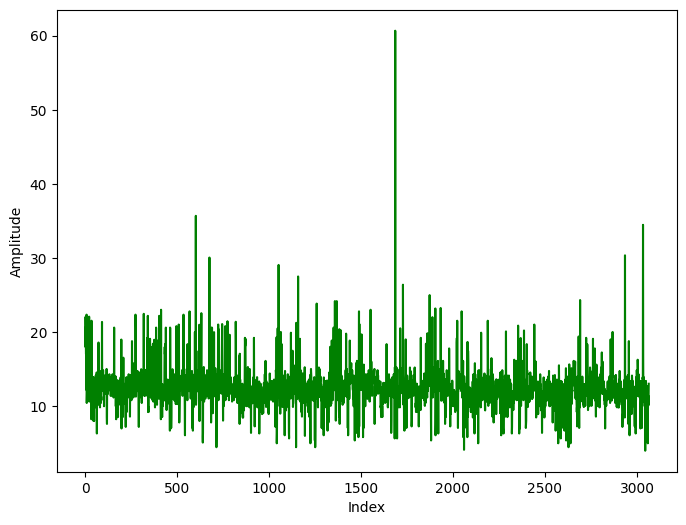

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(amp_dataframes_rx1[10][25],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
# plt.title('Raw CSI Amplitude Data: DD')
plt.show()

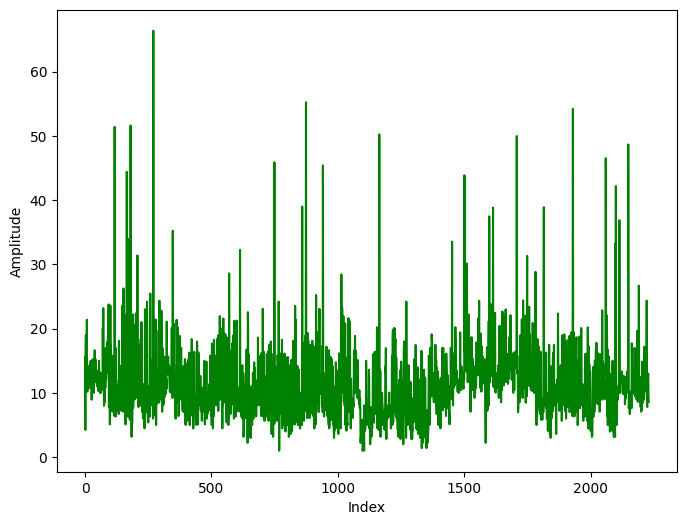

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(amp_dataframes_rx2[10][25],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
# plt.title('Raw CSI Amplitude Data: DD')
plt.show()

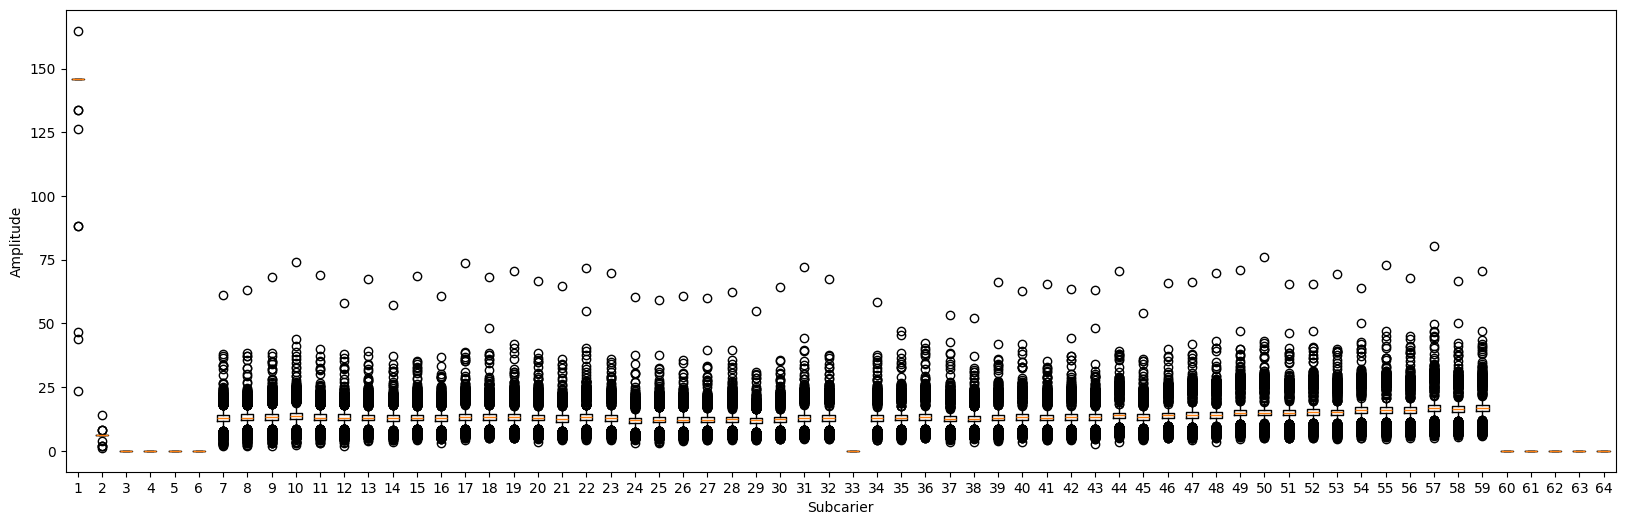

In [22]:
plt.figure(figsize=(20, 6))
plt.boxplot(amp_dataframes_rx1[10])
plt.xlabel('Subcarier')
plt.ylabel('Amplitude')
# plt.title('Boxplot of Before Denoising CSI Amplitude Data')
plt.show()

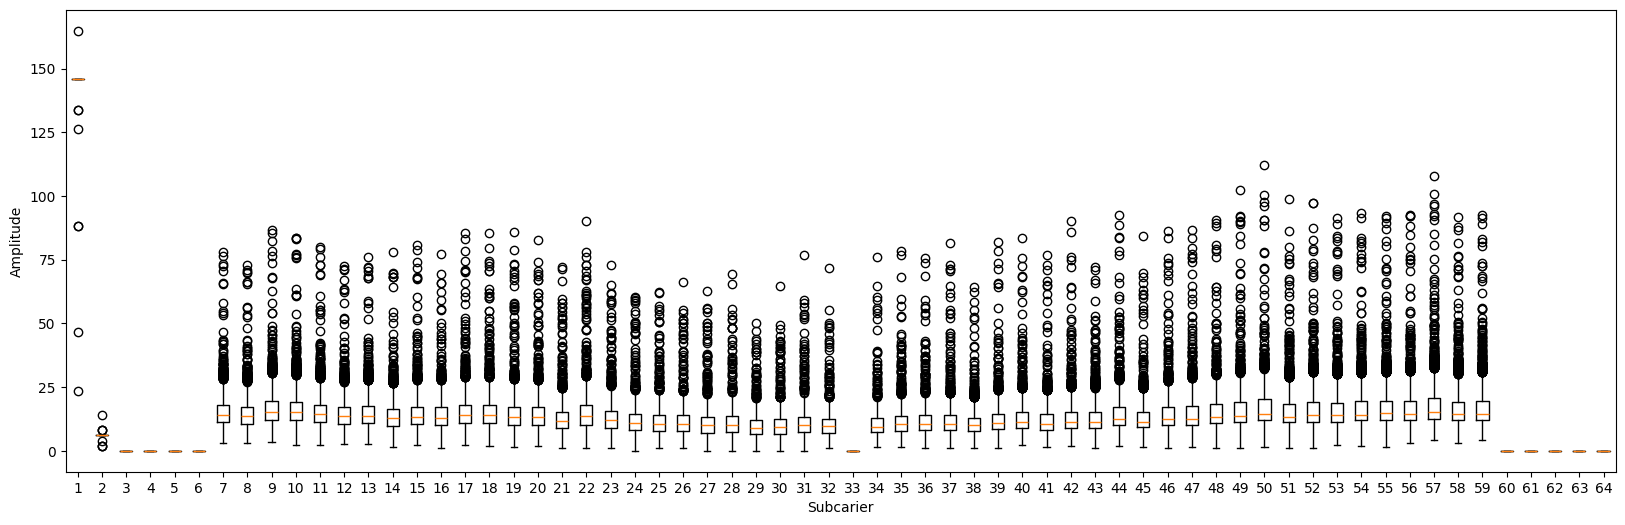

In [23]:
plt.figure(figsize=(20, 6))
plt.boxplot(amp_dataframes_rx2[10])
plt.xlabel('Subcarier')
plt.ylabel('Amplitude')
# plt.title('Boxplot of Before Denoising CSI Amplitude Data')
plt.show()

## Apply noise filter

In [24]:
denoised_dataframes_rx1 = []

for amplitude_RX1 in amp_dataframes_rx1:
    filtered_data_RX1 = pd.DataFrame()
    
    for col_RX1 in amplitude_RX1.columns:
        col_series = amplitude_RX1[col_RX1]
        # Hampel filter
        hampel_filtered = hampel(col_series, window_size=10)
        # Savitzky-Golay filter
        sg_filtered = savgol_filter(hampel_filtered.filtered_data
                                    , window_length=10, polyorder=3)
        filtered_data_RX1[col_RX1] = sg_filtered

    denoised_dataframes_rx1.append(filtered_data_RX1)
    


In [25]:
type(denoised_dataframes_rx1)

list

In [27]:
denoised_dataframes_rx2 = []

for amplitude_RX2 in amp_dataframes_rx2:
    filtered_data_RX2 = pd.DataFrame()
    
    for col_RX2 in amplitude_RX2.columns:
        col_series = amplitude_RX2[col_RX2]
        # Hampel filter
        hampel_filtered = hampel(col_series, window_size=10)
        # Savitzky-Golay filter
        sg_filtered = savgol_filter(hampel_filtered.filtered_data, window_length=10, polyorder=3)
        filtered_data_RX2[col_RX2] = sg_filtered

    denoised_dataframes_rx2.append(filtered_data_RX2)

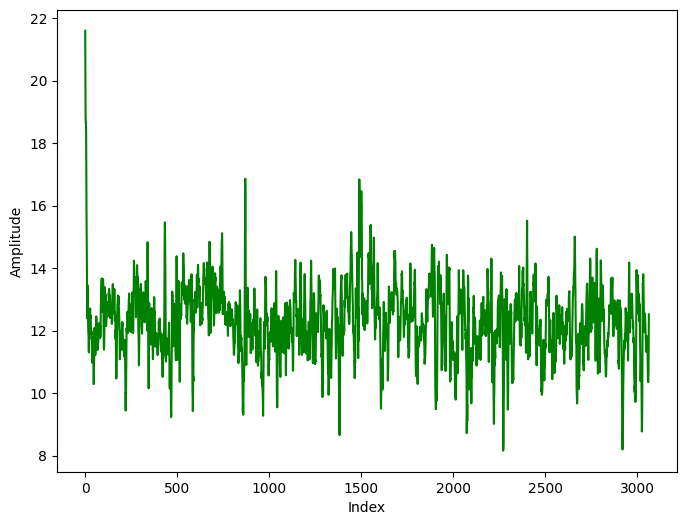

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(denoised_dataframes_rx1[10][25],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
# plt.title('Denoise CSI Amplitude Data: DD')
plt.show()

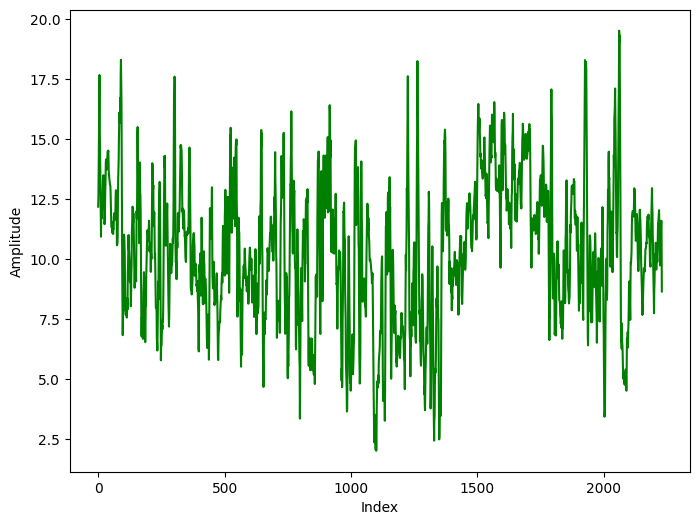

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(denoised_dataframes_rx2[10][25],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
# plt.title('Denoise CSI Amplitude Data: DD')
plt.show()

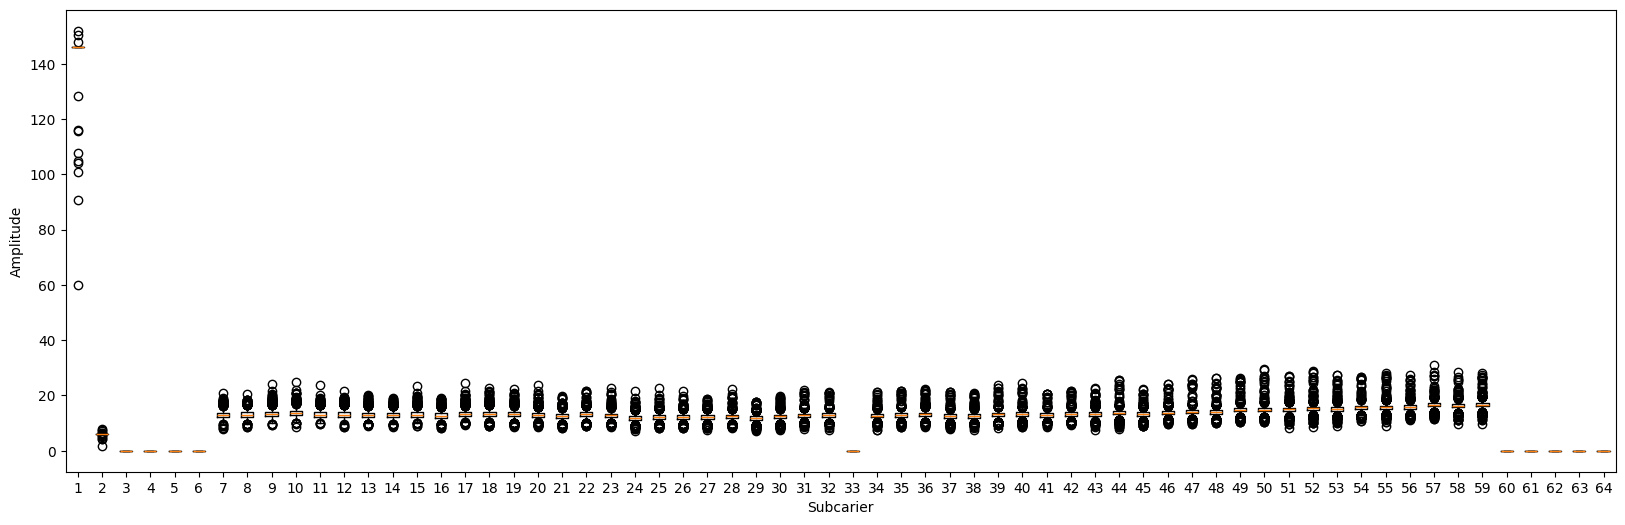

In [30]:
plt.figure(figsize=(20, 6))
plt.boxplot(denoised_dataframes_rx1[10])
plt.xlabel('Subcarier')
plt.ylabel('Amplitude')
# plt.title('Boxplot of Before Denoising CSI Amplitude Data')
plt.show()

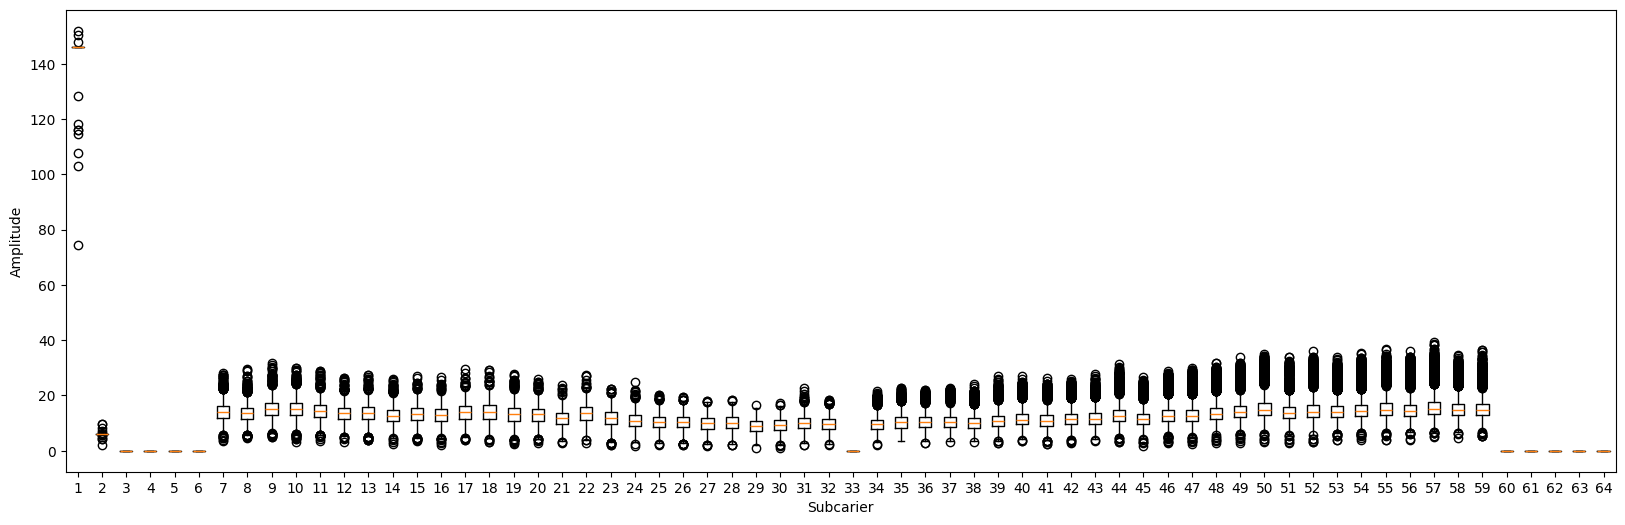

In [31]:
plt.figure(figsize=(20, 6))
plt.boxplot(denoised_dataframes_rx2[10])
plt.xlabel('Subcarier')
plt.ylabel('Amplitude')
# plt.title('Boxplot of Before Denoising CSI Amplitude Data')
plt.show()

In [32]:
denoised_dataframes_rx1[10].describe().to_csv('amp_dataframes_RX1_describe_denois_RX1.csv',index=False)

In [33]:
denoised_dataframes_rx1[10].describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,3065.000000,3065.000000,3065.0,3065.0,3065.0,3065.0,3065.000000,3065.000000,3065.000000,3065.000000,...,3065.000000,3065.000000,3065.000000,3065.000000,3065.000000,3065.0,3065.0,3065.0,3065.0,3065.0
mean,145.877945,5.998401,0.0,0.0,0.0,0.0,13.006063,13.129891,13.416877,13.728498,...,15.733308,15.857758,16.663784,16.336231,16.716806,0.0,0.0,0.0,0.0,0.0
std,2.528069,0.103447,0.0,0.0,0.0,0.0,1.322359,1.300102,1.351568,1.382841,...,1.248057,1.181185,1.196270,1.174668,1.233567,0.0,0.0,0.0,0.0,0.0
min,60.013844,1.804196,0.0,0.0,0.0,0.0,7.945252,8.553781,9.449636,8.485244,...,9.089774,11.129678,11.314062,9.806504,9.722938,0.0,0.0,0.0,0.0,0.0
25%,146.000000,6.000000,0.0,0.0,0.0,0.0,12.130678,12.275401,12.519662,12.819105,...,15.077937,15.176436,16.027830,15.688183,16.040747,0.0,0.0,0.0,0.0,0.0
50%,146.000000,6.000000,0.0,0.0,0.0,0.0,12.875055,12.979152,13.266956,13.541011,...,15.713943,15.830390,16.645720,16.310879,16.711817,0.0,0.0,0.0,0.0,0.0
75%,146.000000,6.000000,0.0,0.0,0.0,0.0,13.794901,13.906649,14.167145,14.500986,...,16.340677,16.492741,17.279125,16.961641,17.342703,0.0,0.0,0.0,0.0,0.0
max,151.970917,7.720280,0.0,0.0,0.0,0.0,20.954729,20.470795,24.038908,24.792353,...,28.029358,27.278997,30.863346,28.582939,28.204218,0.0,0.0,0.0,0.0,0.0


In [34]:
denoised_dataframes_rx2[10].describe().to_csv('amp_dataframes_RX2_describe_denois_RX2.csv',index=False)

In [35]:
denoised_dataframes_rx2[10].describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,2231.000000,2231.000000,2231.0,2231.0,2231.0,2231.0,2231.000000,2231.000000,2231.000000,2231.000000,...,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,2231.0,2231.0,2231.0,2231.0,2231.0
mean,145.875504,6.000589,0.0,0.0,0.0,0.0,14.159041,13.504648,15.112659,15.112037,...,15.797558,15.569998,16.358082,15.648213,15.635390,0.0,0.0,0.0,0.0,0.0
std,2.353083,0.155956,0.0,0.0,0.0,0.0,3.432756,3.342205,3.745689,3.747370,...,4.854773,5.005285,5.134043,4.672202,4.698521,0.0,0.0,0.0,0.0,0.0
min,74.302002,2.027972,0.0,0.0,0.0,0.0,3.682259,4.551425,4.831350,3.166259,...,3.996250,3.837876,5.056916,4.635352,5.171144,0.0,0.0,0.0,0.0,0.0
25%,146.000000,6.000000,0.0,0.0,0.0,0.0,12.005698,11.461574,12.836292,12.822470,...,12.930982,12.704834,13.254590,12.841251,12.859252,0.0,0.0,0.0,0.0,0.0
50%,146.000000,6.000000,0.0,0.0,0.0,0.0,14.095334,13.609236,15.076252,15.003454,...,14.774190,14.400876,15.197034,14.666995,14.708708,0.0,0.0,0.0,0.0,0.0
75%,146.000000,6.000000,0.0,0.0,0.0,0.0,16.110680,15.302438,17.216236,17.292313,...,17.164289,16.668612,17.565389,17.032443,16.855061,0.0,0.0,0.0,0.0,0.0
max,151.970917,9.498835,0.0,0.0,0.0,0.0,28.228334,29.610540,31.697321,29.955240,...,36.683636,36.061234,39.277950,34.792919,36.344707,0.0,0.0,0.0,0.0,0.0


### Save Denoised Amplitudo To Folder RX 1|

In [36]:
# path folder
folder_path_RX1= 'old_datasetfilteredRX1_with_guard'
print("Reading file:", folder_path_RX1)
# Buat folder jika belum ada
if not os.path.exists(folder_path_RX1):
    os.makedirs(folder_path_RX1)

counter = 1
prev_label = None

for i, dataframe in enumerate(denoised_dataframes_rx1):
    if label_list_rx1[i] != prev_label:
        counter = 1
        prev_label = label_list_rx1[i]
    
    filename = f"{label_list_rx1[i]}-{counter}.csv"
    counter += 1
    
    filepath = os.path.join(folder_path_RX1, filename)
    dataframe.to_csv(filepath, index=False)

Reading file: old_datasetfilteredRX1_with_guard


### Load Dataset Amplitudo RX1

In [37]:
# Tentukan folder tempat file CSV berada
folder_path_RX1= 'old_datasetfilteredRX1_with_guard'
print("Reading file:", folder_path_RX1)
# Dapatkan daftar semua file dalam folder tersebut
file_list = [f for f in os.listdir(folder_path_RX1) if f.endswith('.csv')]

# Buat list untuk menyimpan setiap DataFrame
df_list_dd_RX1 = []
df_list_jl_RX1 = []
df_list_bd_RX1 = []



# Baca setiap file CSV, tambahkan kolom label, dan tambahkan ke list yang sesuai
for file_name in file_list:
    file_path = os.path.join(folder_path_RX1, file_name)
    df = pd.read_csv(file_path)
    print("Reading file:", file_path)  # Debugging
    if 'DD' in file_name:
        df['label'] = '0'
        df_list_dd_RX1.append(df)
    elif 'JL' in file_name:
        df['label'] = '1'
        df_list_jl_RX1.append(df)
    elif 'BD' in file_name:
        df['label']='2'
        df_list_bd_RX1.append(df)

# Gabungkan semua DataFrame dengan label '0' menjadi satu DataFrame
dd_df_RX1 = pd.concat(df_list_dd_RX1, ignore_index=True)

# Gabungkan semua DataFrame dengan label '1' menjadi satu DataFrame
jl_df_RX1 = pd.concat(df_list_jl_RX1, ignore_index=True)

# Gabungkan semua DataFrame dengan label '2' menjadi satu DataFrame
bd_df_RX1 = pd.concat(df_list_bd_RX1, ignore_index=True)

print('BD :', len(bd_df_RX1))
print('DD :',len(dd_df_RX1))
print('JL :',len(jl_df_RX1))



Reading file: old_datasetfilteredRX1_with_guard
Reading file: old_datasetfilteredRX1_with_guard\BD-1.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-10.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-11.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-12.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-13.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-14.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-15.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-2.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-3.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-4.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-5.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-6.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-7.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-8.csv
Reading file: old_datasetfilteredRX1_with_guard\BD-9.csv
Reading file: old_datasetfilteredRX1_with_guard\DD-1.csv
Reading file: old_datasetfilteredR

In [38]:
type(jl_df_RX1)

pandas.core.frame.DataFrame

In [39]:
print('BD :', len(bd_df_RX1))
print('DD :',len(dd_df_RX1))
print('JL :',len(jl_df_RX1))

print('Total = ',len(dd_df_RX1)+len(jl_df_RX1)+len(bd_df_RX1))

BD : 43336
DD : 38941
JL : 39409
Total =  121686


### Save Denoised Amplitudo To Folder RX 2

In [40]:
# path folder
folder_path_RX2= 'old_datasetfilteredRX2_with_guard'
print("Reading file:", folder_path_RX2)
# Buat folder jika belum ada
if not os.path.exists(folder_path_RX2):
    os.makedirs(folder_path_RX2)

counter = 1
prev_label = None

for i, dataframe in enumerate(denoised_dataframes_rx2):
    if label_list_rx2[i] != prev_label:
        counter = 1
        prev_label = label_list_rx2[i]
    
    filename = f"{label_list_rx2[i]}-{counter}.csv"
    counter += 1
    
    filepath = os.path.join(folder_path_RX2, filename)
    dataframe.to_csv(filepath, index=False)


Reading file: old_datasetfilteredRX2_with_guard


### Load Dataset Amplitudo RX2

In [41]:
# Tentukan folder tempat file CSV berada
folder_path_RX2= 'old_datasetfilteredRX2_with_guard'
print("Reading file:", folder_path_RX2)
# Dapatkan daftar semua file dalam folder tersebut
file_list = [f for f in os.listdir(folder_path_RX2) if f.endswith('.csv')]

# Buat list untuk menyimpan setiap DataFrame
df_list_dd_RX2 = []
df_list_jl_RX2 = []
df_list_bd_RX2 = []



# Baca setiap file CSV, tambahkan kolom label, dan tambahkan ke list yang sesuai
for file_name in file_list:
    file_path = os.path.join(folder_path_RX2, file_name)
    df = pd.read_csv(file_path)
    print("Reading file:", file_path)  # Debugging
    if 'DD' in file_name:
        df['label'] = '0'
        df_list_dd_RX2.append(df)
    elif 'JL' in file_name:
        df['label'] = '1'
        df_list_jl_RX2.append(df)
    elif 'BD' in file_name:
        df['label']='2'
        df_list_bd_RX2.append(df)

# Gabungkan semua DataFrame dengan label '0' menjadi satu DataFrame
dd_df_RX2 = pd.concat(df_list_dd_RX2, ignore_index=True)

# Gabungkan semua DataFrame dengan label '1' menjadi satu DataFrame
jl_df_RX2 = pd.concat(df_list_jl_RX2, ignore_index=True)

# Gabungkan semua DataFrame dengan label '2' menjadi satu DataFrame
bd_df_RX2 = pd.concat(df_list_bd_RX2, ignore_index=True)

print('BD :', len(bd_df_RX2))
print('DD :',len(dd_df_RX2))
print('JL :',len(jl_df_RX2))


Reading file: old_datasetfilteredRX2_with_guard
Reading file: old_datasetfilteredRX2_with_guard\BD-1.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-10.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-11.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-12.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-13.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-14.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-15.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-2.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-3.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-4.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-5.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-6.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-7.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-8.csv
Reading file: old_datasetfilteredRX2_with_guard\BD-9.csv
Reading file: old_datasetfilteredRX2_with_guard\DD-1.csv
Reading file: old_datasetfilteredR

In [42]:
print('BD :', len(bd_df_RX2))
print('DD :',len(dd_df_RX2))
print('JL :',len(jl_df_RX2))

print('Total = ',len(dd_df_RX2)+len(jl_df_RX2)+len(bd_df_RX2))

BD : 35211
DD : 29619
JL : 30370
Total =  95200


In [43]:
import matplotlib.pyplot as plt

# Hitung jumlah baris untuk setiap label dalam DataFrame dd_df
dd_counts = dd_df_RX1['label'].value_counts()
dd_counts_RX2 = dd_df_RX2['label'].value_counts()
# Hitung jumlah baris untuk setiap label dalam DataFrame jl_df
jl_counts = jl_df_RX1['label'].value_counts()
jl_counts_RX2 = jl_df_RX2['label'].value_counts()
# Hitung jumlah baris untuk setiap label dalam DataFrame bd_df
bd_counts = bd_df_RX1['label'].value_counts()
bd_counts_RX2 = bd_df_RX2['label'].value_counts()

# # Gabungkan count RX1 dan RX2
# dd_counts_total = dd_counts.add(dd_counts_RX2, fill_value=0)
# jl_counts_total = jl_counts.add(jl_counts_RX2, fill_value=0)
# bd_counts_total = bd_counts.add(bd_counts_RX2, fill_value=0)



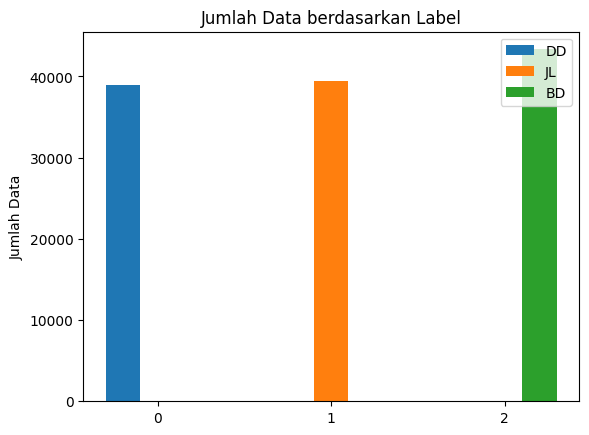

In [44]:
plot_bar_chart(dd_counts, jl_counts, bd_counts)

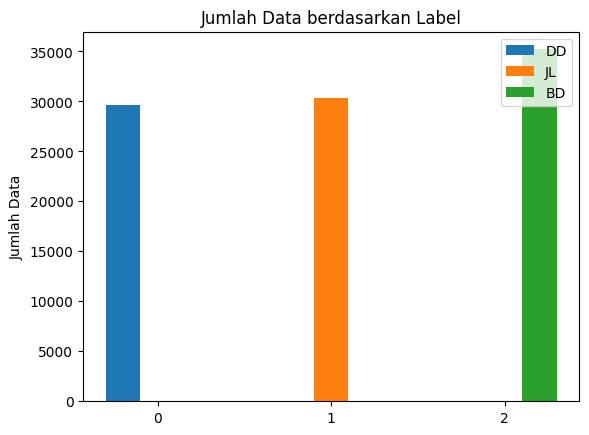

In [45]:
plot_bar_chart(dd_counts_RX2, jl_counts_RX2, bd_counts_RX2)

In [46]:
# Function to identify outliers using IQR
def iqr_outliers(df):
    numeric_df = df.select_dtypes(include=[np.number])
    Q1 = numeric_df.quantile(0.25)
    Q3 = numeric_df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return outliers, numeric_df.columns

In [47]:


# Panggil fungsi outlier detection
outliers_dd_RX1, numeric_cols_dd_RX1 = iqr_outliers(dd_df_RX1)

# Print hasilnya
print("Outliers  duduk RX1:")
outliers_dd_RX1

Outliers  duduk RX1:


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,60.164272,2.019580,0.403661,0.019580,0.097902,0.070598,7.195219,7.185499,6.237174,3.759373,...,32.009853,32.738743,33.709984,33.105660,0.058741,0.070598,0.087566,0.105444,0.261235,0
1,92.453680,7.884382,5.113035,0.248019,1.240093,0.894244,5.482887,4.582400,4.777839,4.158640,...,24.568203,24.496304,24.913400,23.777819,0.744056,0.894244,1.109173,1.335621,3.308982,0
2,107.273790,10.613986,6.722873,0.326107,1.630536,1.175796,4.225416,2.914152,3.625549,4.048348,...,22.615608,22.399399,22.067734,20.728794,0.978322,1.175796,1.458396,1.756141,4.350813,0
3,109.873670,10.961306,6.074132,0.294639,1.473194,1.062335,3.341881,1.975718,2.759616,3.599907,...,24.396418,24.508682,23.351679,22.061940,0.883916,1.062335,1.317664,1.586678,3.930971,0
4,105.502390,9.679255,4.007774,0.194406,0.972028,0.700939,2.751359,1.562058,2.159352,2.984725,...,28.154982,28.884804,26.943930,25.880606,0.583217,0.700939,0.869408,1.046906,2.593694,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38876,146.000000,6.000000,0.000000,0.000000,0.000000,0.000000,3.773344,3.459550,5.148834,3.965531,...,18.500793,18.657131,16.884336,16.173836,0.000000,0.000000,0.000000,0.000000,0.000000,0
38929,146.000000,6.000000,0.000000,0.000000,0.000000,0.000000,3.790824,2.876780,3.210041,3.279066,...,16.359198,17.522220,17.096973,17.488201,0.000000,0.000000,0.000000,0.000000,0.000000,0
38937,146.000000,6.000000,0.000000,0.000000,0.000000,0.000000,5.847579,3.906004,4.365789,3.604859,...,19.663600,20.817934,20.049297,19.969276,0.000000,0.000000,0.000000,0.000000,0.000000,0
38938,146.000000,6.000000,0.000000,0.000000,0.000000,0.000000,6.168006,4.689964,5.181817,4.184118,...,20.604910,21.761019,21.200089,20.412052,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [48]:


# Panggil fungsi outlier detection
outliers_dd_RX2, numeric_cols_dd_RX2 = iqr_outliers(dd_df_RX2)

# Print hasilnya
print("Outliers  duduk RX2:")
outliers_dd_RX2

Outliers  duduk RX2:


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,61.060013,2.646154,0.0,0.0,0.0,0.0,15.358818,15.951185,16.695414,16.509237,...,17.571470,19.706638,19.088877,18.341785,0.0,0.0,0.0,0.0,0.0,0
1,88.103950,4.851282,0.0,0.0,0.0,0.0,17.682760,17.168955,19.784430,18.170880,...,21.737421,22.068802,21.122972,21.272642,0.0,0.0,0.0,0.0,0.0,0
2,103.490295,5.973660,0.0,0.0,0.0,0.0,19.372625,18.409979,21.599747,19.463173,...,24.413265,24.203766,23.018057,23.359203,0.0,0.0,0.0,0.0,0.0,0
3,109.822395,6.238228,0.0,0.0,0.0,0.0,20.490818,19.529850,22.388868,20.401348,...,25.848047,25.940966,24.600866,24.698294,0.0,0.0,0.0,0.0,0.0,0
4,109.703580,5.869930,0.0,0.0,0.0,0.0,21.099745,20.384160,22.399294,21.000631,...,26.290813,27.109837,25.698133,25.386740,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29577,146.000000,6.000000,0.0,0.0,0.0,0.0,17.418980,17.000820,18.062721,18.972412,...,18.139225,19.411627,18.845335,18.099016,0.0,0.0,0.0,0.0,0.0,0
29586,146.000000,6.000000,0.0,0.0,0.0,0.0,17.213263,17.511848,18.289870,19.198597,...,18.512783,19.434875,18.961900,19.270998,0.0,0.0,0.0,0.0,0.0,0
29587,146.000000,6.000000,0.0,0.0,0.0,0.0,17.545467,17.798746,17.853115,19.059092,...,18.653000,19.366251,18.465586,19.219755,0.0,0.0,0.0,0.0,0.0,0
29588,146.000000,6.000000,0.0,0.0,0.0,0.0,17.814707,18.006086,17.581540,18.993038,...,18.840082,19.524340,18.307440,19.516470,0.0,0.0,0.0,0.0,0.0,0


In [49]:


# Panggil fungsi outlier detection
outliers_jl_RX1, numeric_cols_jl_RX1 = iqr_outliers(jl_df_RX1)

# Print hasilnya
print("Outliers  jalan RX 1:")
outliers_jl_RX1

Outliers  jalan RX 1:


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,64.18180,2.587413,0.0,0.0,0.0,0.0,14.193143,18.196283,18.922695,21.215916,...,14.353010,11.616164,11.144075,9.976420,0.0,0.0,0.0,0.0,0.0,1
1,105.30692,6.531468,0.0,0.0,0.0,0.0,6.949971,10.602702,8.372635,9.570320,...,7.675046,6.666140,6.569221,5.413542,0.0,0.0,0.0,0.0,0.0,1
2,129.76526,8.419580,0.0,0.0,0.0,0.0,4.846096,7.691440,4.514241,4.781570,...,4.803629,4.645798,4.352638,3.556663,0.0,0.0,0.0,0.0,0.0,1
3,141.32030,8.839161,0.0,0.0,0.0,0.0,6.460479,8.218203,5.570633,5.125483,...,4.729626,4.964924,4.090426,3.858738,0.0,0.0,0.0,0.0,0.0,1
4,143.73547,8.377623,0.0,0.0,0.0,0.0,10.372077,10.938698,9.764933,8.877873,...,6.443898,7.033303,5.378680,5.772720,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38998,146.00000,6.000000,0.0,0.0,0.0,0.0,29.528894,28.296486,29.516800,29.711157,...,10.184480,12.376107,10.852132,11.356213,0.0,0.0,0.0,0.0,0.0,1
38999,146.00000,6.000000,0.0,0.0,0.0,0.0,31.716724,30.643425,31.527822,31.645836,...,10.973104,12.783358,10.965362,12.211115,0.0,0.0,0.0,0.0,0.0,1
39000,146.00000,6.000000,0.0,0.0,0.0,0.0,32.409687,31.924923,31.726727,33.304950,...,11.140940,12.352392,10.710320,12.339404,0.0,0.0,0.0,0.0,0.0,1
39193,146.00000,6.000000,0.0,0.0,0.0,0.0,18.244457,18.716673,18.825243,20.613712,...,13.934255,14.393702,13.465807,13.149208,0.0,0.0,0.0,0.0,0.0,1


In [50]:


# Panggil fungsi outlier detection
outliers_jl_RX2, numeric_cols_jl_RX2 = iqr_outliers(jl_df_RX2)

# Print hasilnya
print("Outliers  jalan RX 2:")
outliers_jl_RX2

Outliers  jalan RX 2:


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,60.013844,1.804196,0.0,0.0,0.0,0.0,25.955397,26.093860,30.203780,29.094183,...,23.880997,24.478298,22.830898,22.181566,0.0,0.0,0.0,0.0,0.0,1
1,90.548230,5.156177,0.0,0.0,0.0,0.0,25.992434,25.207733,29.406199,27.973238,...,23.068874,24.024462,22.299278,21.799974,0.0,0.0,0.0,0.0,0.0,1
2,104.768420,7.026806,0.0,0.0,0.0,0.0,24.902660,23.696316,27.847230,26.351759,...,22.455452,23.801867,21.818895,21.359580,0.0,0.0,0.0,0.0,0.0,1
3,107.610060,7.720280,0.0,0.0,0.0,0.0,23.049635,21.803007,25.785948,24.430964,...,21.935568,23.661217,21.353003,20.867828,0.0,0.0,0.0,0.0,0.0,1
4,104.008835,7.540793,0.0,0.0,0.0,0.0,20.796913,19.771208,23.481428,22.412066,...,21.404062,23.453215,20.864855,20.332174,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30365,146.000000,6.000000,0.0,0.0,0.0,0.0,23.885399,23.726583,24.213352,24.620182,...,11.097672,12.053998,11.039680,11.338191,0.0,0.0,0.0,0.0,0.0,1
30366,146.000000,6.000000,0.0,0.0,0.0,0.0,22.179047,22.317146,22.894527,23.189522,...,11.190602,12.295867,11.375563,11.417687,0.0,0.0,0.0,0.0,0.0,1
30367,146.000000,6.000000,0.0,0.0,0.0,0.0,21.076122,21.605398,22.288027,22.639124,...,11.860396,12.884735,12.280791,11.932612,0.0,0.0,0.0,0.0,0.0,1
30368,146.000000,6.000000,0.0,0.0,0.0,0.0,21.133698,22.117731,22.897545,23.570246,...,13.322728,13.900372,13.908195,13.056490,0.0,0.0,0.0,0.0,0.0,1


In [51]:


# Panggil fungsi outlier detection
outliers_bd_RX1, numeric_cols_bd_RX1 = iqr_outliers(bd_df_RX1)

# Print hasilnya
print("Outliers  berdiri RX1:")
outliers_bd_RX1

Outliers  berdiri RX1:


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,60.013844,1.804196,0.0,0.0,0.0,0.0,23.960388,24.918170,27.913101,24.156616,...,28.951984,29.304546,28.066162,27.849540,0.0,0.0,0.0,0.0,0.0,2
1,90.548230,5.156177,0.0,0.0,0.0,0.0,19.663970,19.995943,22.250338,20.916512,...,24.403011,25.947365,24.320934,25.414492,0.0,0.0,0.0,0.0,0.0,2
2,104.768420,7.026806,0.0,0.0,0.0,0.0,17.848646,17.866943,19.812166,19.990997,...,22.520603,24.867214,23.080498,24.667257,0.0,0.0,0.0,0.0,0.0,2
3,107.610060,7.720280,0.0,0.0,0.0,0.0,17.765661,17.698795,19.636925,20.589067,...,22.472850,25.276457,23.523668,24.993500,0.0,0.0,0.0,0.0,0.0,2
4,104.008835,7.540793,0.0,0.0,0.0,0.0,18.666262,18.659126,20.762959,21.919716,...,23.427835,26.387450,24.829262,25.778875,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43317,146.000000,6.000000,0.0,0.0,0.0,0.0,11.964005,12.833904,11.898459,12.370927,...,17.433203,17.761097,17.355220,17.569304,0.0,0.0,0.0,0.0,0.0,2
43318,146.000000,6.000000,0.0,0.0,0.0,0.0,12.039199,13.028326,11.936626,12.132927,...,17.218134,17.858088,17.186316,17.701630,0.0,0.0,0.0,0.0,0.0,2
43319,146.000000,6.000000,0.0,0.0,0.0,0.0,12.275731,13.005161,11.931512,11.884032,...,17.233010,17.545671,17.138378,17.423363,0.0,0.0,0.0,0.0,0.0,2
43329,146.000000,6.000000,0.0,0.0,0.0,0.0,13.749049,13.490611,13.260939,12.967720,...,18.595560,19.367018,19.272530,19.098316,0.0,0.0,0.0,0.0,0.0,2


In [52]:
# bd_df_total = pd.concat([bd_df_RX1, bd_df_RX2], ignore_index=True)

# Panggil fungsi outlier detection
outliers_bd_RX2, numeric_cols_bd_RX2 = iqr_outliers(bd_df_RX2)

# Print hasilnya
print("Outliers  berdiri RX2:")
outliers_bd_RX2

Outliers  berdiri RX2:


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,60.013844,1.804196,0.0,0.0,0.0,0.0,48.192535,47.106697,50.978676,52.606354,...,25.055770,23.168493,26.222717,23.294130,0.0,0.0,0.0,0.0,0.0,2
1,90.548230,5.156177,0.0,0.0,0.0,0.0,30.775421,29.013128,31.040424,29.638268,...,28.874596,28.051119,28.627136,27.894625,0.0,0.0,0.0,0.0,0.0,2
2,104.768420,7.026806,0.0,0.0,0.0,0.0,20.465408,18.857431,19.394958,16.472912,...,30.023070,30.751410,29.490660,29.806290,0.0,0.0,0.0,0.0,0.0,2
3,107.610060,7.720280,0.0,0.0,0.0,0.0,15.714270,14.787004,14.206549,10.959786,...,29.069090,31.534350,29.087059,29.580393,0.0,0.0,0.0,0.0,0.0,2
4,104.008835,7.540793,0.0,0.0,0.0,0.0,14.973772,14.949242,13.639466,10.948387,...,26.580555,30.664919,27.690107,27.768198,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35159,146.000000,6.000000,0.0,0.0,0.0,0.0,16.650146,13.533463,14.240202,15.428490,...,19.997953,18.334780,21.316414,17.322994,0.0,0.0,0.0,0.0,0.0,2
35206,146.000000,6.000000,0.0,0.0,0.0,0.0,18.572180,15.057531,16.009241,15.919346,...,22.796501,24.325583,24.837439,23.827114,0.0,0.0,0.0,0.0,0.0,2
35207,146.000000,6.000000,0.0,0.0,0.0,0.0,21.076975,15.491415,16.091380,16.005789,...,25.913109,27.761065,28.717627,28.533876,0.0,0.0,0.0,0.0,0.0,2
35208,146.000000,6.000000,0.0,0.0,0.0,0.0,21.727398,15.558088,15.552510,15.837364,...,26.521816,28.282934,29.418657,30.149137,0.0,0.0,0.0,0.0,0.0,2


C:\Users\Hp\AppData\Local\Temp\ipykernel_9520\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


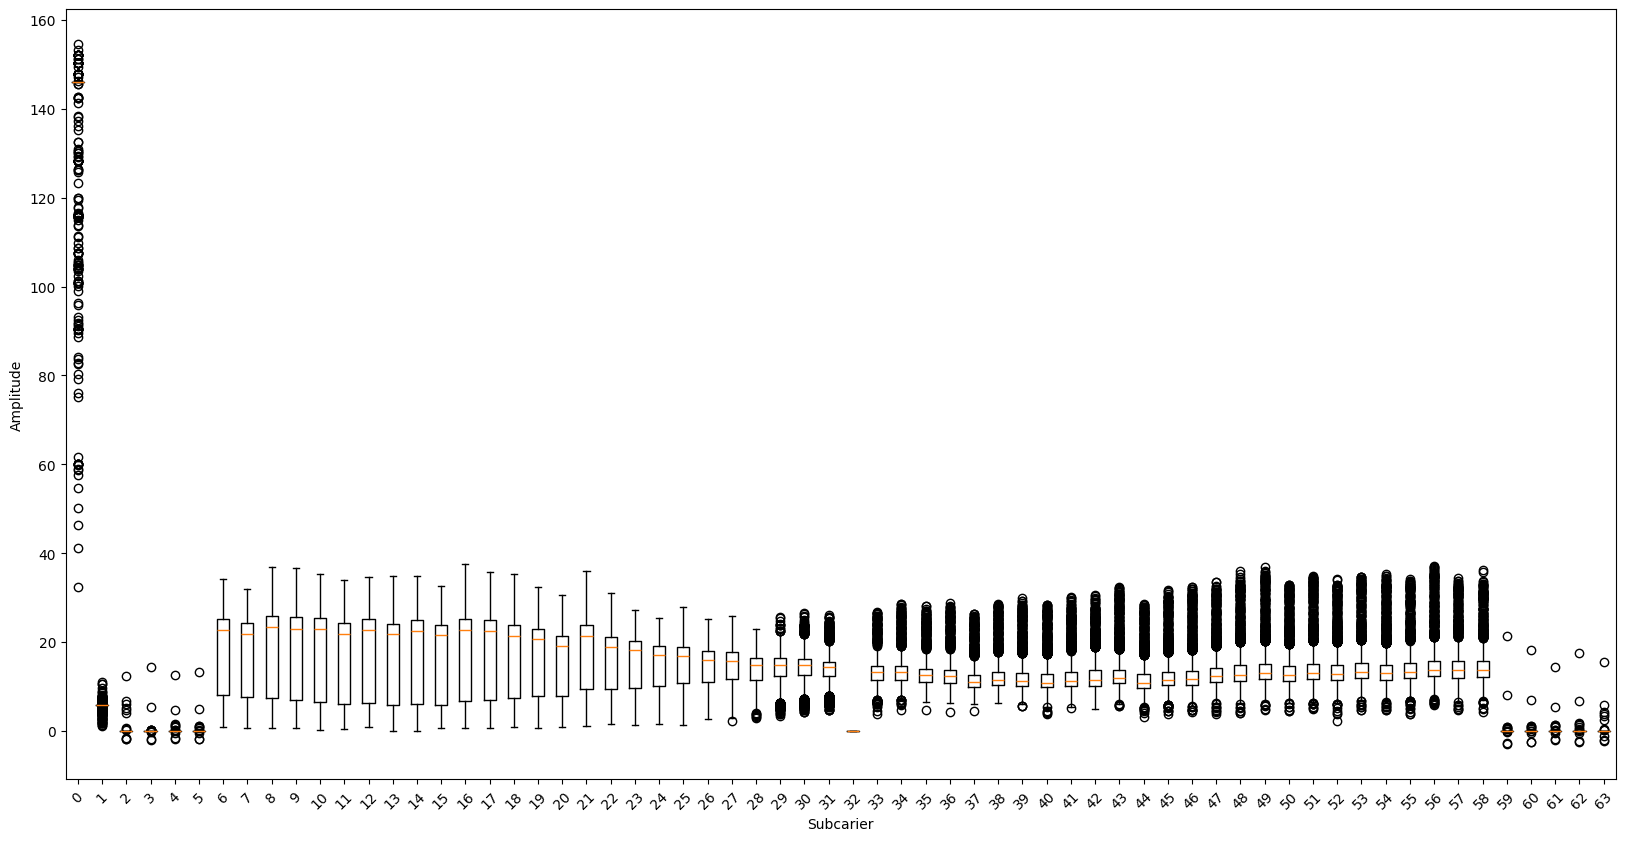

In [53]:
outliers_iqr_dd_without_label = outliers_dd_RX1.drop(columns=['label'])
plot_boxplots(outliers_iqr_dd_without_label,'Boxplot Before Normalization Amplituo Data')  

In [54]:
cleaned_jl_df_RX1 = jl_df_RX1.drop(outliers_jl_RX1.index)
cleaned_bd_df_RX1 = bd_df_RX1.drop(outliers_bd_RX1.index)
cleaned_dd_df_RX1 = dd_df_RX1.drop(outliers_dd_RX1.index)

cleaned_jl_df_RX2 = jl_df_RX2.drop(outliers_jl_RX2.index)
cleaned_bd_df_RX2 = bd_df_RX2.drop(outliers_bd_RX2.index)
cleaned_dd_df_RX2 = dd_df_RX2.drop(outliers_dd_RX2.index)



C:\Users\Hp\AppData\Local\Temp\ipykernel_9520\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


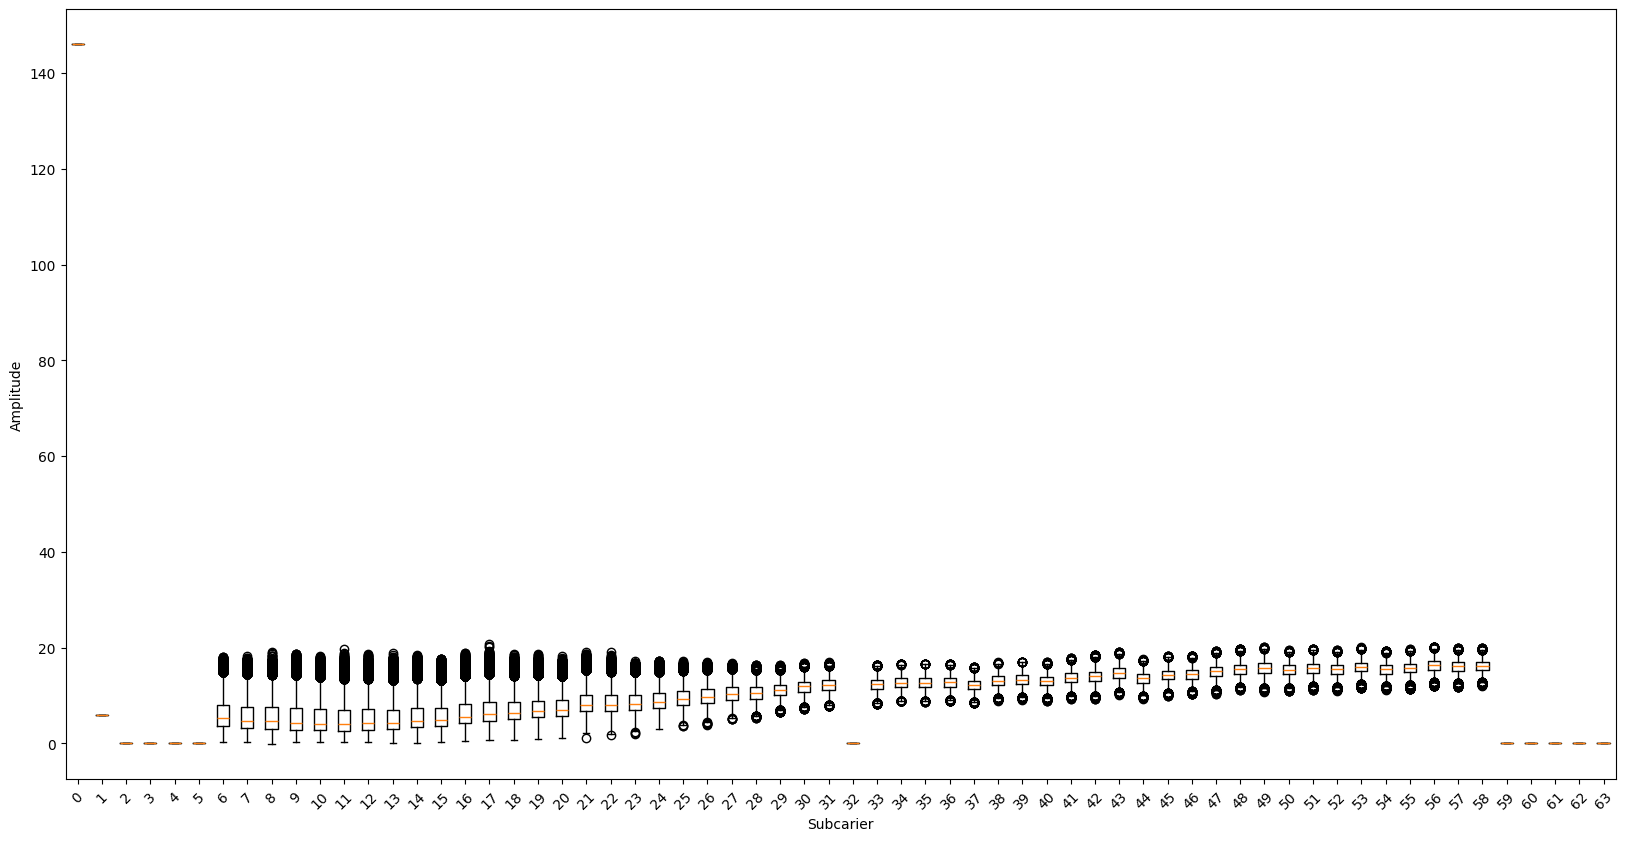

In [55]:
cleaned_dd_df_RX1_without_label = cleaned_dd_df_RX1.drop(columns=['label'])
plot_boxplots(cleaned_dd_df_RX1_without_label,'Boxplot Before Normalization Amplituo Data')  

C:\Users\Hp\AppData\Local\Temp\ipykernel_9520\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


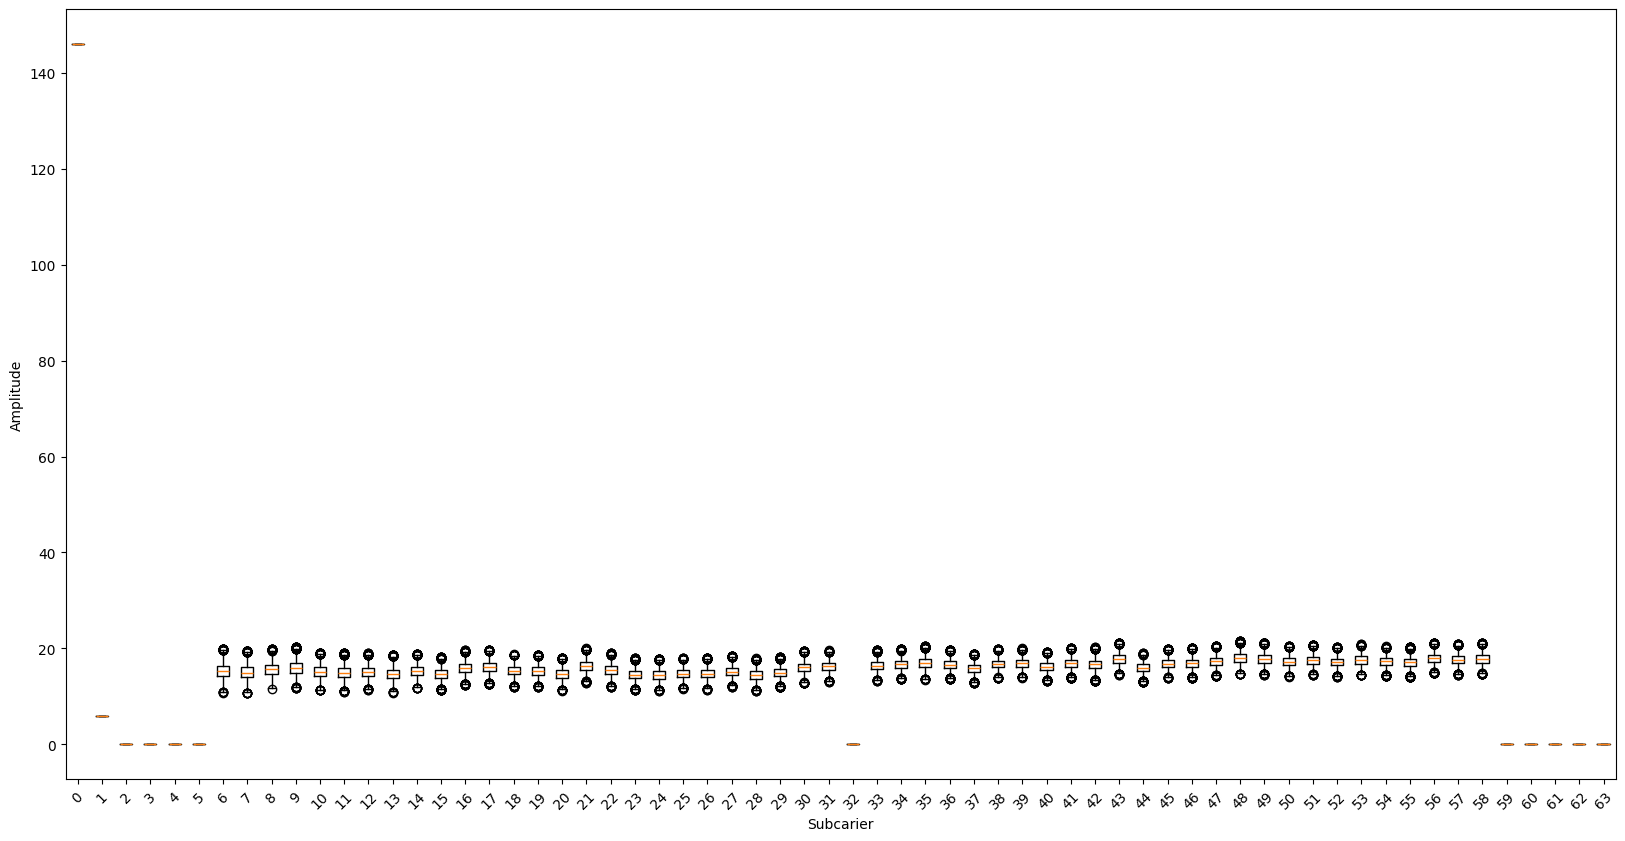

In [56]:
cleaned_dd_df_RX2_without_label = cleaned_dd_df_RX2.drop(columns=['label'])
plot_boxplots(cleaned_dd_df_RX2_without_label,'Boxplot Before Normalization Amplituo Data')  

In [57]:

# Apply RobustScaler
scaler = RobustScaler()
scaled_jl_data_RX1 = scaler.fit_transform(cleaned_jl_df_RX1[numeric_cols_jl_RX1])
scaled_bd_data_RX1 = scaler.fit_transform(cleaned_bd_df_RX1[numeric_cols_bd_RX1])
scaled_dd_data_RX1 = scaler.fit_transform(cleaned_dd_df_RX1[numeric_cols_dd_RX1])

scaled_jl_data_RX2 = scaler.fit_transform(cleaned_jl_df_RX2[numeric_cols_jl_RX2])
scaled_bd_data_RX2 = scaler.fit_transform(cleaned_bd_df_RX2[numeric_cols_bd_RX2]) 
scaled_dd_data_RX2 = scaler.fit_transform(cleaned_dd_df_RX2[numeric_cols_dd_RX2])

# Convert the scaled data back to a DataFrame
scaled_jl_df_RX1 = pd.DataFrame(scaled_jl_data_RX1, columns=numeric_cols_jl_RX1, index=cleaned_jl_df_RX1.index)
scaled_bd_df_RX1 = pd.DataFrame(scaled_bd_data_RX1, columns=numeric_cols_bd_RX1, index=cleaned_bd_df_RX1.index)
scaled_dd_df_RX1 = pd.DataFrame(scaled_dd_data_RX1, columns=numeric_cols_dd_RX1, index=cleaned_dd_df_RX1.index)

scaled_jl_df_RX2 = pd.DataFrame(scaled_jl_data_RX2, columns=numeric_cols_jl_RX2, index=cleaned_jl_df_RX2.index)
scaled_bd_df_RX2 = pd.DataFrame(scaled_bd_data_RX2, columns=numeric_cols_bd_RX2, index=cleaned_bd_df_RX2.index)
scaled_dd_df_RX2 = pd.DataFrame(scaled_dd_data_RX2, columns=numeric_cols_dd_RX2, index=cleaned_dd_df_RX2.index)

# If you want to combine the scaled numeric columns back with the non-numeric columns:
final_jl_df_RX1 = pd.concat([scaled_jl_df_RX1, cleaned_jl_df_RX1.drop(columns=numeric_cols_jl_RX1)], axis=1)
final_bd_df_RX1 = pd.concat([scaled_bd_df_RX1, cleaned_bd_df_RX1.drop(columns=numeric_cols_bd_RX1)], axis=1)
final_dd_df_RX1 = pd.concat([scaled_dd_df_RX1, cleaned_dd_df_RX1.drop(columns=numeric_cols_dd_RX1)], axis=1)

final_jl_df_RX2 = pd.concat([scaled_jl_df_RX2, cleaned_jl_df_RX2.drop(columns=numeric_cols_jl_RX2)], axis=1)
final_bd_df_RX2 = pd.concat([scaled_bd_df_RX2, cleaned_bd_df_RX2.drop(columns=numeric_cols_bd_RX2)], axis=1)
final_dd_df_RX2 = pd.concat([scaled_dd_df_RX2, cleaned_dd_df_RX2.drop(columns=numeric_cols_dd_RX2)], axis=1)




C:\Users\Hp\AppData\Local\Temp\ipykernel_9520\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


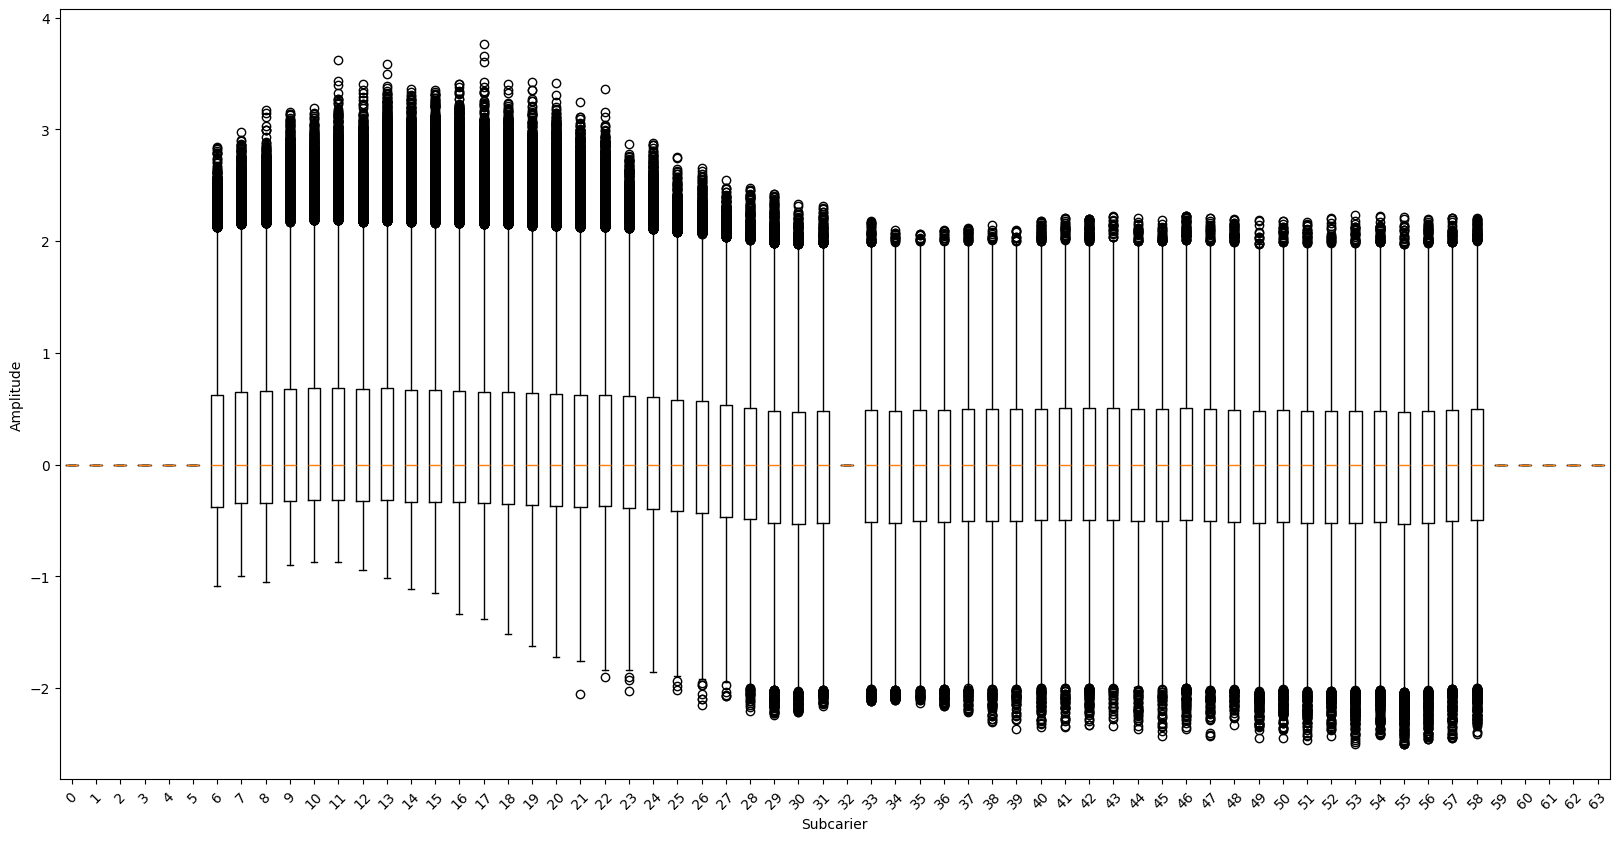

In [58]:
final_RX1_iqr_dd_without_label = final_dd_df_RX1.drop(columns=['label'])
plot_boxplots(final_RX1_iqr_dd_without_label,'Boxplot Before Normalization Amplituo Data')  

C:\Users\Hp\AppData\Local\Temp\ipykernel_9520\2851536282.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_data, labels=df.columns)


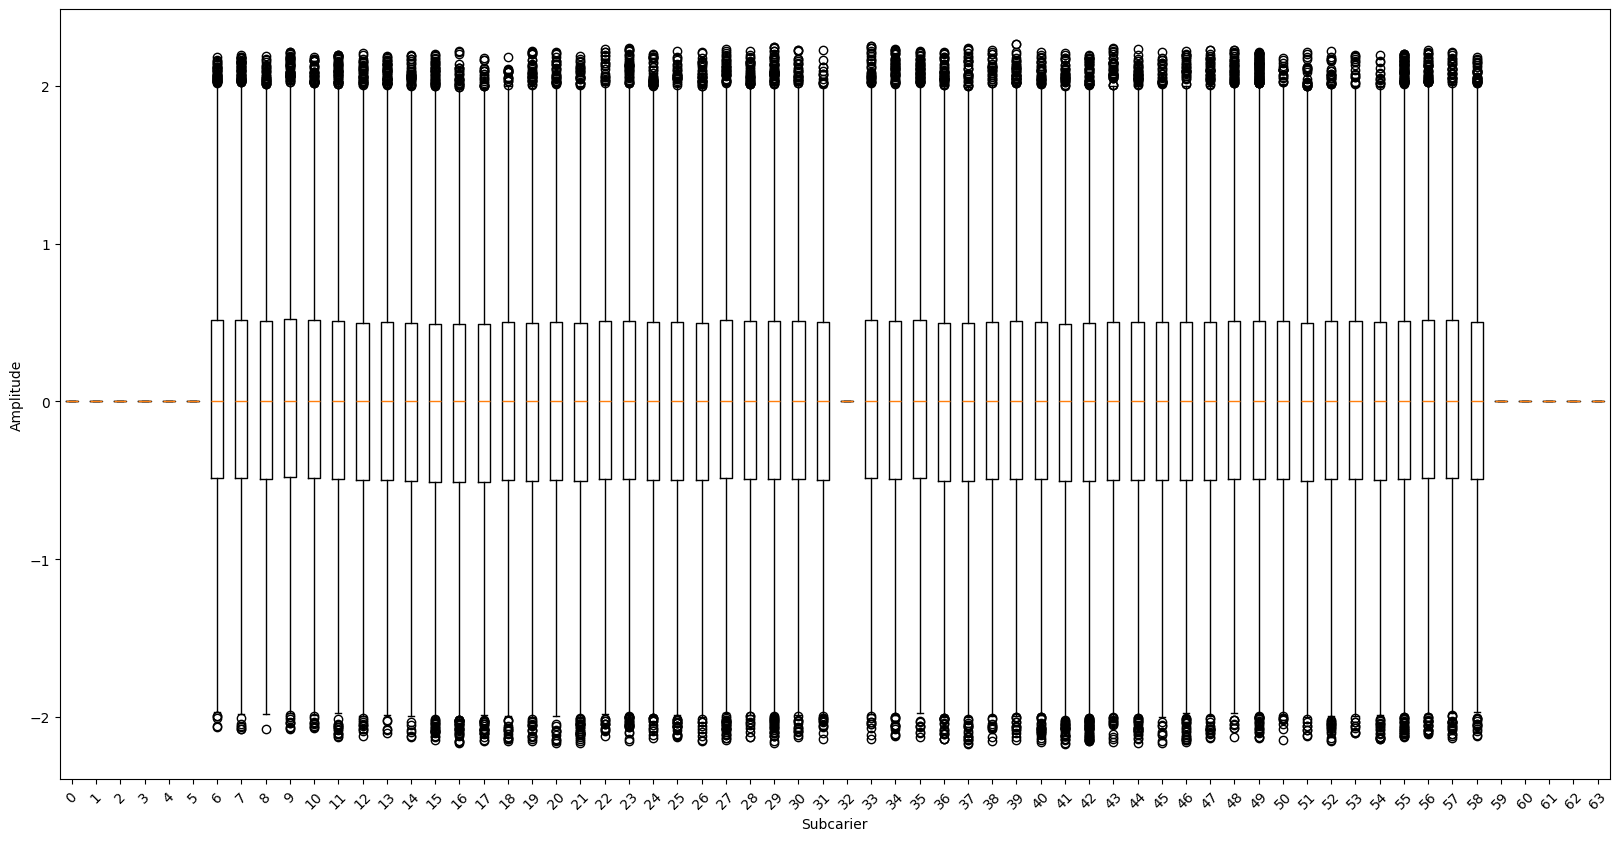

In [59]:
final_RX2_iqr_dd_without_label = final_dd_df_RX2.drop(columns=['label'])
plot_boxplots(final_RX2_iqr_dd_without_label,'Boxplot Before Normalization Amplituo Data')  

In [60]:
print("dd Data after removing outliers and applying RobustScaler:")
final_dd_df_RX1

dd Data after removing outliers and applying RobustScaler:


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
13,0.0,0.0,0.0,0.0,0.0,0.0,-0.947893,-0.695013,-0.555633,-0.531368,...,-0.591015,-0.195035,-0.545372,-0.275980,0.0,0.0,0.0,0.0,0.0,0
14,0.0,0.0,0.0,0.0,0.0,0.0,-0.960364,-0.715869,-0.522060,-0.517570,...,-0.675033,-0.299667,-0.590925,-0.188866,0.0,0.0,0.0,0.0,0.0,0
15,0.0,0.0,0.0,0.0,0.0,0.0,-0.917598,-0.690541,-0.509406,-0.527676,...,-0.811116,-0.530887,-0.504607,-0.331613,0.0,0.0,0.0,0.0,0.0,0
16,0.0,0.0,0.0,0.0,0.0,0.0,-0.886240,-0.660801,-0.506526,-0.547003,...,-0.778439,-0.512576,-0.450479,-0.202188,0.0,0.0,0.0,0.0,0.0,0
17,0.0,0.0,0.0,0.0,0.0,0.0,-0.901677,-0.655109,-0.581723,-0.565143,...,-0.579923,-0.445122,-0.218340,-0.185262,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38933,0.0,0.0,0.0,0.0,0.0,0.0,-0.210288,-0.387303,-0.417557,-0.412698,...,-0.362192,-1.262937,-1.245061,-0.536486,0.0,0.0,0.0,0.0,0.0,0
38934,0.0,0.0,0.0,0.0,0.0,0.0,-0.137159,-0.379140,-0.320073,-0.385240,...,0.337337,-0.275909,-0.294803,0.223850,0.0,0.0,0.0,0.0,0.0,0
38935,0.0,0.0,0.0,0.0,0.0,0.0,0.011240,-0.297476,-0.243349,-0.338915,...,0.755352,0.474217,0.419144,0.805473,0.0,0.0,0.0,0.0,0.0,0
38936,0.0,0.0,0.0,0.0,0.0,0.0,0.052057,-0.275442,-0.187566,-0.283849,...,1.269827,1.243735,1.091991,1.366571,0.0,0.0,0.0,0.0,0.0,0


In [61]:
print("dd RX 2 Data after removing outliers and applying RobustScaler:")
final_dd_df_RX2

dd RX 2 Data after removing outliers and applying RobustScaler:


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
14,0.0,0.0,0.0,0.0,0.0,0.0,1.326735,0.939777,0.970821,0.836524,...,1.728273,1.638420,1.516737,1.106827,0.0,0.0,0.0,0.0,0.0,0
15,0.0,0.0,0.0,0.0,0.0,0.0,1.269218,1.051603,0.847143,0.660644,...,1.699628,1.513270,1.673121,1.200598,0.0,0.0,0.0,0.0,0.0,0
16,0.0,0.0,0.0,0.0,0.0,0.0,1.180761,0.998624,0.619610,0.467211,...,1.645697,1.407870,1.626520,1.225547,0.0,0.0,0.0,0.0,0.0,0
17,0.0,0.0,0.0,0.0,0.0,0.0,1.099272,1.034036,0.704919,0.442904,...,1.537373,1.541025,2.073624,1.424784,0.0,0.0,0.0,0.0,0.0,0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.972995,1.007372,0.790141,0.448557,...,1.457470,1.566297,2.046145,1.629815,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29614,0.0,0.0,0.0,0.0,0.0,0.0,0.305147,0.294060,0.592895,0.752145,...,1.147713,1.368040,0.895289,1.234959,0.0,0.0,0.0,0.0,0.0,0
29615,0.0,0.0,0.0,0.0,0.0,0.0,0.381774,0.326867,0.748023,1.016407,...,1.581307,1.522564,0.912029,1.423248,0.0,0.0,0.0,0.0,0.0,0
29616,0.0,0.0,0.0,0.0,0.0,0.0,0.367661,0.306804,0.707413,1.023939,...,1.602785,1.415022,0.857518,1.403468,0.0,0.0,0.0,0.0,0.0,0
29617,0.0,0.0,0.0,0.0,0.0,0.0,0.204135,0.186765,0.362016,0.624142,...,1.010091,0.919744,0.703942,1.065402,0.0,0.0,0.0,0.0,0.0,0


In [62]:
print("JL Data after removing outliers and applying RobustScaler:")
final_jl_df_RX1

JL Data after removing outliers and applying RobustScaler:


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
17,0.0,0.0,0.0,0.0,0.0,0.0,0.086095,0.115162,0.201183,0.252782,...,-0.680588,-0.752041,-0.464898,-0.224217,0.0,0.0,0.0,0.0,0.0,1
18,0.0,0.0,0.0,0.0,0.0,0.0,-0.041288,-0.049423,-0.007007,0.106601,...,-0.675775,-0.596178,-0.401816,-0.350547,0.0,0.0,0.0,0.0,0.0,1
19,0.0,0.0,0.0,0.0,0.0,0.0,-0.170396,-0.154167,-0.019362,0.057732,...,-0.746633,-0.491403,-0.441861,-0.408516,0.0,0.0,0.0,0.0,0.0,1
20,0.0,0.0,0.0,0.0,0.0,0.0,-0.057163,-0.011599,-0.060497,0.033439,...,-0.878971,-0.684590,-0.754933,-0.713098,0.0,0.0,0.0,0.0,0.0,1
21,0.0,0.0,0.0,0.0,0.0,0.0,0.082634,0.115010,0.010319,0.084159,...,-0.971935,-0.753484,-1.000457,-0.920855,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39404,0.0,0.0,0.0,0.0,0.0,0.0,0.067528,0.154734,0.203491,0.186613,...,-0.795401,-0.656177,-0.646696,-0.787427,0.0,0.0,0.0,0.0,0.0,1
39405,0.0,0.0,0.0,0.0,0.0,0.0,0.035964,0.157818,0.184094,0.201464,...,-0.797285,-0.701932,-0.689505,-0.870313,0.0,0.0,0.0,0.0,0.0,1
39406,0.0,0.0,0.0,0.0,0.0,0.0,0.114852,0.249061,0.236432,0.294757,...,-0.674795,-0.719230,-0.662624,-0.846281,0.0,0.0,0.0,0.0,0.0,1
39407,0.0,0.0,0.0,0.0,0.0,0.0,0.348678,0.457567,0.383005,0.488304,...,-0.387612,-0.695952,-0.536613,-0.666562,0.0,0.0,0.0,0.0,0.0,1


In [63]:
print("JL Data after removing outliers and applying RobustScaler:")
final_jl_df_RX2

JL Data after removing outliers and applying RobustScaler:


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
13,0.0,0.0,0.0,0.0,0.0,0.0,0.857007,0.713064,0.836837,0.371896,...,0.694847,0.440512,0.258854,0.365454,0.0,0.0,0.0,0.0,0.0,1
14,0.0,0.0,0.0,0.0,0.0,0.0,0.919518,0.845087,0.841415,0.501981,...,0.441055,0.362844,0.297115,0.251268,0.0,0.0,0.0,0.0,0.0,1
15,0.0,0.0,0.0,0.0,0.0,0.0,0.710277,0.556064,0.549285,0.226086,...,-0.107118,-0.108385,-0.007850,-0.247491,0.0,0.0,0.0,0.0,0.0,1
16,0.0,0.0,0.0,0.0,0.0,0.0,0.754715,0.699364,0.694825,0.384442,...,-0.138271,-0.086689,-0.072264,-0.303339,0.0,0.0,0.0,0.0,0.0,1
17,0.0,0.0,0.0,0.0,0.0,0.0,0.652686,0.602808,0.573901,0.455798,...,-0.365854,-0.436046,-0.321033,-0.549890,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30348,0.0,0.0,0.0,0.0,0.0,0.0,0.545626,0.341804,0.411071,0.289800,...,0.221547,0.108469,0.170082,0.511598,0.0,0.0,0.0,0.0,0.0,1
30349,0.0,0.0,0.0,0.0,0.0,0.0,0.897977,0.825391,0.739253,0.707636,...,-0.020292,0.002338,0.152359,0.478692,0.0,0.0,0.0,0.0,0.0,1
30350,0.0,0.0,0.0,0.0,0.0,0.0,1.499724,1.431702,1.296173,1.193403,...,-0.542314,-0.476401,-0.373988,0.163380,0.0,0.0,0.0,0.0,0.0,1
30351,0.0,0.0,0.0,0.0,0.0,0.0,1.821692,1.859654,1.553176,1.513835,...,-0.854895,-0.799484,-0.657301,-0.284507,0.0,0.0,0.0,0.0,0.0,1


In [64]:
print("BD Data after removing outliers and applying RobustScaler:")
final_bd_df_RX2

BD Data after removing outliers and applying RobustScaler:


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
27,0.0,0.0,0.0,0.0,0.0,0.0,-0.676339,-0.907501,-0.707996,-0.326439,...,-1.284787,-1.172102,-1.454978,-1.486838,0.0,0.0,0.0,0.0,0.0,2
28,0.0,0.0,0.0,0.0,0.0,0.0,-0.857558,-1.134729,-0.839274,-0.439908,...,-1.199726,-1.279289,-1.476612,-1.700589,0.0,0.0,0.0,0.0,0.0,2
29,0.0,0.0,0.0,0.0,0.0,0.0,-0.716786,-1.020121,-0.710084,-0.412877,...,-1.099610,-1.230507,-1.257809,-1.367509,0.0,0.0,0.0,0.0,0.0,2
30,0.0,0.0,0.0,0.0,0.0,0.0,-0.697635,-0.877604,-0.649029,-0.408098,...,-0.953429,-0.988769,-0.959328,-0.815103,0.0,0.0,0.0,0.0,0.0,2
31,0.0,0.0,0.0,0.0,0.0,0.0,-0.533623,-0.590560,-0.577152,-0.487569,...,-0.012763,-0.227248,-0.174807,0.305996,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35202,0.0,0.0,0.0,0.0,0.0,0.0,-0.251413,-0.060899,-0.238254,-0.101368,...,0.099895,1.032596,0.300687,0.707013,0.0,0.0,0.0,0.0,0.0,2
35203,0.0,0.0,0.0,0.0,0.0,0.0,-0.385402,-0.181621,-0.265711,-0.156040,...,-0.409628,0.152439,-0.237085,-0.205397,0.0,0.0,0.0,0.0,0.0,2
35204,0.0,0.0,0.0,0.0,0.0,0.0,-0.236234,-0.269152,-0.168050,-0.213412,...,0.719499,0.912641,0.773008,0.631359,0.0,0.0,0.0,0.0,0.0,2
35205,0.0,0.0,0.0,0.0,0.0,0.0,-0.006983,-0.208324,-0.168991,-0.219386,...,1.583392,1.598157,1.768925,1.483375,0.0,0.0,0.0,0.0,0.0,2


In [65]:
print("BD Data after removing outliers and applying RobustScaler:")
final_bd_df_RX2

BD Data after removing outliers and applying RobustScaler:


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
27,0.0,0.0,0.0,0.0,0.0,0.0,-0.676339,-0.907501,-0.707996,-0.326439,...,-1.284787,-1.172102,-1.454978,-1.486838,0.0,0.0,0.0,0.0,0.0,2
28,0.0,0.0,0.0,0.0,0.0,0.0,-0.857558,-1.134729,-0.839274,-0.439908,...,-1.199726,-1.279289,-1.476612,-1.700589,0.0,0.0,0.0,0.0,0.0,2
29,0.0,0.0,0.0,0.0,0.0,0.0,-0.716786,-1.020121,-0.710084,-0.412877,...,-1.099610,-1.230507,-1.257809,-1.367509,0.0,0.0,0.0,0.0,0.0,2
30,0.0,0.0,0.0,0.0,0.0,0.0,-0.697635,-0.877604,-0.649029,-0.408098,...,-0.953429,-0.988769,-0.959328,-0.815103,0.0,0.0,0.0,0.0,0.0,2
31,0.0,0.0,0.0,0.0,0.0,0.0,-0.533623,-0.590560,-0.577152,-0.487569,...,-0.012763,-0.227248,-0.174807,0.305996,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35202,0.0,0.0,0.0,0.0,0.0,0.0,-0.251413,-0.060899,-0.238254,-0.101368,...,0.099895,1.032596,0.300687,0.707013,0.0,0.0,0.0,0.0,0.0,2
35203,0.0,0.0,0.0,0.0,0.0,0.0,-0.385402,-0.181621,-0.265711,-0.156040,...,-0.409628,0.152439,-0.237085,-0.205397,0.0,0.0,0.0,0.0,0.0,2
35204,0.0,0.0,0.0,0.0,0.0,0.0,-0.236234,-0.269152,-0.168050,-0.213412,...,0.719499,0.912641,0.773008,0.631359,0.0,0.0,0.0,0.0,0.0,2
35205,0.0,0.0,0.0,0.0,0.0,0.0,-0.006983,-0.208324,-0.168991,-0.219386,...,1.583392,1.598157,1.768925,1.483375,0.0,0.0,0.0,0.0,0.0,2


In [66]:
print(len(final_dd_df_RX1))
print(len(final_jl_df_RX1))
print(len(final_bd_df_RX1))

print('Total = ',len(final_dd_df_RX1)+len(final_jl_df_RX1)+len(final_bd_df_RX1))

33524
37485
36817
Total =  107826


In [67]:
print(len(final_dd_df_RX2))
print(len(final_jl_df_RX2))
print(len(final_bd_df_RX2))

print('Total = ',len(final_dd_df_RX2)+len(final_jl_df_RX2)+len(final_bd_df_RX2))

26454
25576
33074
Total =  85104


In [68]:
merged_df_RX1 = pd.concat([final_dd_df_RX1,
                       final_jl_df_RX1,
                       final_bd_df_RX1
                       ], axis=0)
merged_df_RX1

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
13,0.0,0.0,0.0,0.0,0.0,0.0,-0.947893,-0.695013,-0.555633,-0.531368,...,-0.591015,-0.195035,-0.545372,-0.275980,0.0,0.0,0.0,0.0,0.0,0
14,0.0,0.0,0.0,0.0,0.0,0.0,-0.960364,-0.715869,-0.522060,-0.517570,...,-0.675033,-0.299667,-0.590925,-0.188866,0.0,0.0,0.0,0.0,0.0,0
15,0.0,0.0,0.0,0.0,0.0,0.0,-0.917598,-0.690541,-0.509406,-0.527676,...,-0.811116,-0.530887,-0.504607,-0.331613,0.0,0.0,0.0,0.0,0.0,0
16,0.0,0.0,0.0,0.0,0.0,0.0,-0.886240,-0.660801,-0.506526,-0.547003,...,-0.778439,-0.512576,-0.450479,-0.202188,0.0,0.0,0.0,0.0,0.0,0
17,0.0,0.0,0.0,0.0,0.0,0.0,-0.901677,-0.655109,-0.581723,-0.565143,...,-0.579923,-0.445122,-0.218340,-0.185262,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43331,0.0,0.0,0.0,0.0,0.0,0.0,0.579966,0.341870,0.344583,0.433671,...,1.459709,2.133423,1.864655,1.160497,0.0,0.0,0.0,0.0,0.0,2
43332,0.0,0.0,0.0,0.0,0.0,0.0,0.296509,-0.063974,0.224089,0.340930,...,0.779518,1.728568,1.071269,0.444298,0.0,0.0,0.0,0.0,0.0,2
43333,0.0,0.0,0.0,0.0,0.0,0.0,0.035416,-0.416970,0.060496,0.188527,...,0.124456,1.014056,0.211502,-0.247310,0.0,0.0,0.0,0.0,0.0,2
43334,0.0,0.0,0.0,0.0,0.0,0.0,-0.145762,-0.626583,-0.141953,-0.020646,...,-0.345186,-0.026674,-0.558917,-0.770671,0.0,0.0,0.0,0.0,0.0,2


In [69]:
merged_df_RX2 = pd.concat([final_dd_df_RX2,
                       final_jl_df_RX2,
                       final_bd_df_RX2
                       ], axis=0)
merged_df_RX2

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
14,0.0,0.0,0.0,0.0,0.0,0.0,1.326735,0.939777,0.970821,0.836524,...,1.728273,1.638420,1.516737,1.106827,0.0,0.0,0.0,0.0,0.0,0
15,0.0,0.0,0.0,0.0,0.0,0.0,1.269218,1.051603,0.847143,0.660644,...,1.699628,1.513270,1.673121,1.200598,0.0,0.0,0.0,0.0,0.0,0
16,0.0,0.0,0.0,0.0,0.0,0.0,1.180761,0.998624,0.619610,0.467211,...,1.645697,1.407870,1.626520,1.225547,0.0,0.0,0.0,0.0,0.0,0
17,0.0,0.0,0.0,0.0,0.0,0.0,1.099272,1.034036,0.704919,0.442904,...,1.537373,1.541025,2.073624,1.424784,0.0,0.0,0.0,0.0,0.0,0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.972995,1.007372,0.790141,0.448557,...,1.457470,1.566297,2.046145,1.629815,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35202,0.0,0.0,0.0,0.0,0.0,0.0,-0.251413,-0.060899,-0.238254,-0.101368,...,0.099895,1.032596,0.300687,0.707013,0.0,0.0,0.0,0.0,0.0,2
35203,0.0,0.0,0.0,0.0,0.0,0.0,-0.385402,-0.181621,-0.265711,-0.156040,...,-0.409628,0.152439,-0.237085,-0.205397,0.0,0.0,0.0,0.0,0.0,2
35204,0.0,0.0,0.0,0.0,0.0,0.0,-0.236234,-0.269152,-0.168050,-0.213412,...,0.719499,0.912641,0.773008,0.631359,0.0,0.0,0.0,0.0,0.0,2
35205,0.0,0.0,0.0,0.0,0.0,0.0,-0.006983,-0.208324,-0.168991,-0.219386,...,1.583392,1.598157,1.768925,1.483375,0.0,0.0,0.0,0.0,0.0,2


In [70]:
threshold = 0.9  # 90% nilai 0

# Hitung persentase nol di setiap kolom
zero_ratio = (merged_df_RX1 == 0).sum() / len(merged_df_RX1)

# Cari kolom yang lebih dari threshold
columns_to_drop = zero_ratio[zero_ratio > threshold].index.tolist()

print("Kolom yang mostly nol (>90%):")
print(columns_to_drop)


Kolom yang mostly nol (>90%):
['0', '1', '2', '3', '4', '5', '32', '59', '60', '61', '62', '63']


In [71]:
threshold = 0.9  # 90% nilai 0

# Hitung persentase nol di setiap kolom
zero_ratio = (merged_df_RX2 == 0).sum() / len(merged_df_RX2)

# Cari kolom yang lebih dari threshold
columns_to_drop = zero_ratio[zero_ratio > threshold].index.tolist()

print("Kolom yang mostly nol (>90%):")
print(columns_to_drop)


Kolom yang mostly nol (>90%):
['0', '1', '2', '3', '4', '5', '32', '59', '60', '61', '62', '63']


In [72]:
merged_df_RX1.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,107826.0,107826.0,107826.0,107826.0,107826.0,107826.0,107826.000000,107826.000000,107826.000000,107826.000000,...,107766.000000,107765.000000,107762.000000,107761.000000,107761.000000,107761.0,107761.0,107761.0,107761.0,107761.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.075361,0.095230,0.096180,0.116685,...,-0.013593,-0.015410,-0.012986,-0.006016,-0.000735,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.676254,0.687647,0.694056,0.707907,...,0.712160,0.712235,0.715168,0.709123,0.712455,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,-2.164520,-2.190188,-1.938471,-2.094492,...,-2.424843,-2.503597,-2.458477,-2.444735,-2.407220,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,-0.440645,-0.420847,-0.424017,-0.405024,...,-0.510490,-0.509620,-0.508435,-0.503275,-0.500462,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.544165,0.558127,0.550521,0.565422,...,0.489113,0.488882,0.491505,0.497107,0.499595,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,2.839272,2.975727,3.177710,3.156039,...,2.221343,2.215831,2.201740,2.209122,2.206624,0.0,0.0,0.0,0.0,0.0


In [73]:
merged_df_RX2.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,85104.0,85104.0,85104.0,85104.0,85104.0,85104.0,8.510400e+04,8.510400e+04,8.510400e+04,85104.000000,...,85104.000000,85104.000000,85104.000000,8.510400e+04,8.510400e+04,85104.0,85104.0,85104.0,85104.0,85104.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,1.208045e-01,1.065575e-01,1.175271e-01,0.113364,...,0.004555,0.004713,0.005154,3.005278e-03,4.457188e-03,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,7.427059e-01,7.439034e-01,7.573686e-01,0.765772,...,0.710824,0.717025,0.718571,7.168241e-01,7.212078e-01,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,-2.110771e+00,-2.357007e+00,-2.389575e+00,-2.134611,...,-2.240619,-2.239322,-2.259629,-2.276176e+00,-2.304633e+00,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,-3.926962e-01,-4.137054e-01,-3.936988e-01,-0.402604,...,-0.498887,-0.496394,-0.494783,-4.971182e-01,-4.954764e-01,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,-4.110871e-16,-3.474538e-16,-4.546517e-16,0.000000,...,0.000000,0.000000,0.000000,-5.403469e-16,1.173870e-15,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,5.976995e-01,5.808834e-01,5.950564e-01,0.590127,...,0.500973,0.502161,0.504837,5.031257e-01,5.036781e-01,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,2.949977e+00,2.927504e+00,3.015352e+00,3.077747,...,2.196735,2.203161,2.225134,2.213310e+00,2.179289e+00,0.0,0.0,0.0,0.0,0.0


## Split Data

In [74]:
# Set seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [75]:
from sklearn.model_selection import train_test_split

# Asumsikan merged_df sudah didefinisikan sebelumnya
X_RX1 = merged_df_RX1.iloc[:, :-1]
y_RX1 = merged_df_RX1.iloc[:, -1]
# # Gabungkan menjadi satu dataframe
data = X_RX1.copy()
data['label'] = y_RX1
# # Drop NaN di seluruh data
data = data.dropna()

# # Pisahkan lagi
X_RX1 = data.drop(columns=['label'])
y_RX1 = data['label']
# Baris-baris di atas adalah persiapan data Anda, biarkan seperti itu.
# Kita akan fokus pada bagian setelah X dan y siap.

# Tahap 1: Pisahkan data menjadi data latih (70%) dan data sementara (30%)
# Data sementara ini akan dibagi lagi menjadi validasi dan uji.
# Gunakan stratify=y jika Anda ingin menjaga proporsi kelas (berguna untuk klasifikasi)
X_train_RX1, X_temp_RX1, y_train_RX1, y_temp_RX1 = train_test_split(
    X_RX1, y_RX1,
    test_size=0.30,  # 30% untuk data sementara (validasi + uji)
    random_state=seed,
    shuffle=True,
    stratify=y_RX1 # Tambahkan jika y adalah target klasifikasi dan Anda ingin stratifikasi
)

# Tahap 2: Pisahkan data sementara (30% dari total) menjadi data validasi dan data uji.
# Kita ingin validasi 20% dari total dan uji 10% dari total.
# Dari data sementara (30%), kita ambil 1/3 untuk uji (0.30 * 1/3 = 0.10 atau 10% dari total).
# Sisanya (2/3 dari data sementara) akan menjadi data validasi (0.30 * 2/3 = 0.20 atau 20% dari total).
X_val_RX1, X_test_RX1, y_val_RX1, y_test_RX1 = train_test_split(
    X_temp_RX1, y_temp_RX1,
    test_size=0.3333,  # Sekitar 1/3 dari X_temp untuk data uji (menghasilkan 10% dari total data)
    random_state=seed,
    shuffle=True,
    stratify=y_temp_RX1 # Tambahkan jika y_temp adalah target klasifikasi dan Anda ingin stratifikasi
)

# Sekarang Anda memiliki:
# X_train, y_train (70% dari data asli)
# X_val, y_val (20% dari data asli, untuk validasi)
# X_test, y_test (10% dari data asli, untuk pengujian akhir)

print(f"Ukuran X_train_RX1: {X_train_RX1.shape}, Ukuran y_train_RX1: {y_train_RX1.shape}")
print(f"Ukuran X_val_RX1: {X_val_RX1.shape}, Ukuran y_val_RX1: {y_val_RX1.shape}")
print(f"Ukuran X_test_RX1: {X_test_RX1.shape}, Ukuran y_test_RX1: {y_test_RX1.shape}")

Ukuran X_train_RX1: (75432, 64), Ukuran y_train_RX1: (75432,)
Ukuran X_val_RX1: (21553, 64), Ukuran y_val_RX1: (21553,)
Ukuran X_test_RX1: (10776, 64), Ukuran y_test_RX1: (10776,)


In [76]:
from sklearn.model_selection import train_test_split

# Asumsikan merged_df sudah didefinisikan sebelumnya
X_RX2 = merged_df_RX2.iloc[:, :-1]
y_RX2 = merged_df_RX2.iloc[:, -1]
# # Gabungkan menjadi satu dataframe
data = X_RX2.copy()
data['label'] = y_RX2
# # Drop NaN di seluruh data
data = data.dropna()

# # Pisahkan lagi
X_RX2 = data.drop(columns=['label'])
y_RX2 = data['label']
# Baris-baris di atas adalah persiapan data Anda, biarkan seperti itu.
# Kita akan fokus pada bagian setelah X dan y siap.

# Tahap 1: Pisahkan data menjadi data latih (70%) dan data sementara (30%)
# Data sementara ini akan dibagi lagi menjadi validasi dan uji.
# Gunakan stratify=y jika Anda ingin menjaga proporsi kelas (berguna untuk klasifikasi)
X_train_RX2, X_temp_RX2, y_train_RX2, y_temp_RX2 = train_test_split(
    X_RX2, y_RX2,
    test_size=0.30,  # 30% untuk data sementara (validasi + uji)
    random_state=seed,
    shuffle=True,
    stratify=y_RX2 # Tambahkan jika y adalah target klasifikasi dan Anda ingin stratifikasi
)

# Tahap 2: Pisahkan data sementara (30% dari total) menjadi data validasi dan data uji.
# Kita ingin validasi 20% dari total dan uji 10% dari total.
# Dari data sementara (30%), kita ambil 1/3 untuk uji (0.30 * 1/3 = 0.10 atau 10% dari total).
# Sisanya (2/3 dari data sementara) akan menjadi data validasi (0.30 * 2/3 = 0.20 atau 20% dari total).
X_val_RX2, X_test_RX2, y_val_RX2, y_test_RX2 = train_test_split(
    X_temp_RX2, y_temp_RX2,
    test_size=0.3333,  # Sekitar 1/3 dari X_temp untuk data uji (menghasilkan 10% dari total data)
    random_state=seed,
    shuffle=True,
    stratify=y_temp_RX2 # Tambahkan jika y_temp adalah target klasifikasi dan Anda ingin stratifikasi
)

# Sekarang Anda memiliki:
# X_train, y_train (70% dari data asli)
# X_val, y_val (20% dari data asli, untuk validasi)
# X_test, y_test (10% dari data asli, untuk pengujian akhir)

print(f"Ukuran X_train_RX2: {X_train_RX2.shape}, Ukuran y_train_RX2: {y_train_RX2.shape}")
print(f"Ukuran X_val_RX2: {X_val_RX2.shape}, Ukuran y_val_RX2: {y_val_RX2.shape}")
print(f"Ukuran X_test_RX2: {X_test_RX2.shape}, Ukuran y_test_RX2: {y_test_RX2.shape}")

Ukuran X_train_RX2: (59572, 64), Ukuran y_train_RX2: (59572,)
Ukuran X_val_RX2: (17022, 64), Ukuran y_val_RX2: (17022,)
Ukuran X_test_RX2: (8510, 64), Ukuran y_test_RX2: (8510,)


In [77]:
from imblearn.over_sampling import SMOTE


# Terapkan SMOTE
smote = SMOTE(random_state=seed)
X_train_smote_RX1, y_train_smote_RX1= smote.fit_resample(X_train_RX1, y_train_RX1)
# X_test_smote_RX1, y_test_smote_RX1 = smote.fit_resample(X_test_RX1, y_test_RX1)

print("Shape data setelah SMOTE:")
print(f"X_train_smote _RX1: {X_train_smote_RX1.shape}, y_train_smote _RX1: {y_train_smote_RX1.shape}")
# print(f"X_test_smote _RX1: {X_test_smote_RX1.shape}, y_test_smote _RX1: {y_test_smote_RX1.shape}")

Shape data setelah SMOTE:
X_train_smote _RX1: (78717, 64), y_train_smote _RX1: (78717,)


In [78]:
# Terapkan SMOTE
smote = SMOTE(random_state=seed)
X_train_smote_RX2, y_train_smote_RX2 = smote.fit_resample(X_train_RX2, y_train_RX2)
# X_test_smote_RX2, y_test_smote_RX2 = smote.fit_resample(X_test_RX2, y_test_RX2)

print("Shape data setelah SMOTE:")
print(f"X_train_smote_RX2: {X_train_smote_RX2.shape}, y_train_smote_RX2: {y_train_smote_RX2.shape}")
# print(f"X_test_smote_RX2: {X_test_smote_RX2.shape}, y_test_smote_RX2: {y_test_smote_RX2.shape}")

Shape data setelah SMOTE:
X_train_smote_RX2: (69453, 64), y_train_smote_RX2: (69453,)


In [79]:
# Hitung jumlah sampel di setiap kelas
unique_classes_RX1, class_counts_RX1 = np.unique(y_train_smote_RX1, return_counts=True)

# Tampilkan jumlah sampel di setiap kelas
for cls, count_RX1 in zip(unique_classes_RX1, class_counts_RX1):
    print(f"Kelas {cls} RX1: {count_RX1} sampel")


Kelas 0 RX1: 26239 sampel
Kelas 1 RX1: 26239 sampel
Kelas 2 RX1: 26239 sampel


In [80]:
# Hitung jumlah sampel di setiap kelas
unique_classes_RX2, class_counts_RX2 = np.unique(y_train_smote_RX2, return_counts=True)

# Tampilkan jumlah sampel di setiap kelas
for cls, count_RX2 in zip(unique_classes_RX2, class_counts_RX2):
    print(f"Kelas {cls} RX2: {count_RX2} sampel")


Kelas 0 RX2: 23151 sampel
Kelas 1 RX2: 23151 sampel
Kelas 2 RX2: 23151 sampel


In [81]:
class_counts_RX1

array([26239, 26239, 26239])

In [82]:
class_counts_RX2

array([23151, 23151, 23151])

In [83]:
unique_classes_RX1


array(['0', '1', '2'], dtype=object)

In [84]:
unique_classes_RX1


array(['0', '1', '2'], dtype=object)

In [85]:
dd_counts_smote_RX1 = {str(0): class_counts_RX1[0]}
jl_counts_smote_RX1 = {str(1): class_counts_RX1[1]}
bd_counts_smote_RX1 = {str(2): class_counts_RX1[2]}


In [86]:
dd_counts_smote_RX1

{'0': np.int64(26239)}

In [87]:
dd_counts_smote_RX2 = {str(0): class_counts_RX2[0]}
jl_counts_smote_RX2 = {str(1): class_counts_RX2[1]}
bd_counts_smote_RX2 = {str(2): class_counts_RX2[2]}


In [88]:
dd_counts_smote_RX2

{'0': np.int64(23151)}

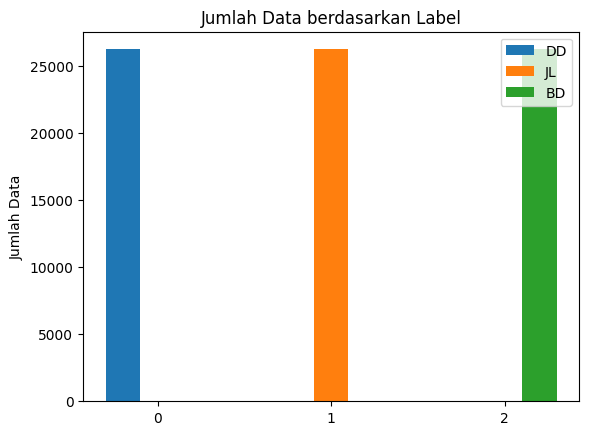

In [89]:
plot_bar_chart(dd_counts_smote_RX1, jl_counts_smote_RX1, bd_counts_smote_RX1)

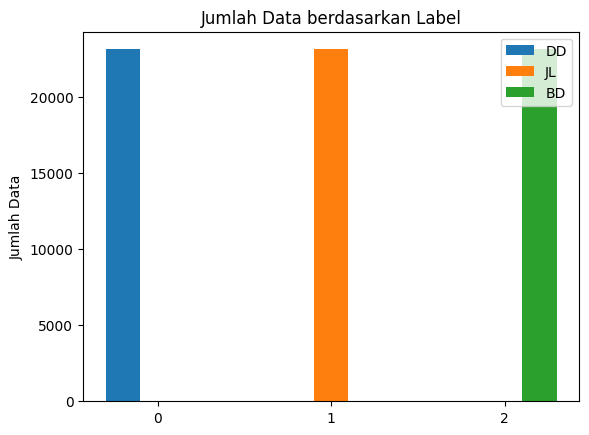

In [90]:
plot_bar_chart(dd_counts_smote_RX2, jl_counts_smote_RX2, bd_counts_smote_RX2)

In [91]:
print(X_train_smote_RX1.shape)
print(y_train_smote_RX1.shape)
# print(X_test_smote_RX1.shape)
# print(y_test_smote_RX1.shape)

(78717, 64)
(78717,)


In [92]:
print(X_train_smote_RX2.shape)
print(y_train_smote_RX2.shape)
# print(X_test_smote_RX2.shape)
# print(y_test_smote_RX2.shape)

(69453, 64)
(69453,)


# Trainng With Filtration and Normalization (Robust Scaler) Balancing (SMOTE)



In [93]:
# Cukup definisikan kelas Attention satu kali
import tensorflow as tf
# import numpy as np # Sudah diimpor biasanya
# import itertools # Untuk plot_confusion_matrix
# import matplotlib.pyplot as plt # Untuk plot_confusion_matrix dan plot history

class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        dim = int(input_shape[-1]) # Pastikan integer
        self.W = self.add_weight(name="att_weight", shape=(dim, dim), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(dim,), initializer="zeros", trainable=True)
        self.u = self.add_weight(name="att_u", shape=(dim,), initializer="glorot_uniform", trainable=True)
        super(Attention, self).build(input_shape) # Panggil build parent

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1)
        return output

    def get_config(self): # Penting untuk save/load model dengan custom layer
        config = super(Attention, self).get_config()
        return config

In [94]:
def get_MLP_model(input_dim, learning_rate,num_classes, lstm_units, dense_units):
    InputLayer = tf.keras.layers.InputLayer
    Dense = tf.keras.layers.Dense
    LSTM = tf.keras.layers.LSTM
    Dropout = tf.keras.layers.Dropout

    model = tf.keras.Sequential(
      [
          InputLayer(input_shape=input_dim),
          LSTM(lstm_units, return_sequences=True),
          Attention(),
        #   Dropout(dropout_rate),
          Dense(dense_units, activation=tf.nn.relu),
        #   Dropout(dropout_rate),
          Dense(num_classes, activation=tf.nn.softmax)
      ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [95]:
# def get_MLP_model(input_dim, learning_rate, num_classes):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Input(shape=input_dim),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])
    
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
#     model.compile(
#         loss='sparse_categorical_crossentropy', 
#         optimizer=optimizer, 
#         metrics=['accuracy']
#     )
    
#     return model


In [96]:
flat_data_RX1 = np.array(X_train_smote_RX1)
flat_data_RX1 = flat_data_RX1.reshape((X_train_smote_RX1.shape[0], 1, flat_data_RX1.shape[1]))

label_in_RX1 = np.array(y_train_smote_RX1)
label_in_RX1 = label_in_RX1.astype(np.float64)

# Menambah Dimensi Baru: Penambahan dimensi baru (dengan nilai 1) sering kali diperlukan untuk menyesuaikan 
# data ke dalam bentuk yang diharapkan oleh model tertentu. Misalnya, model LSTM atau CNN sering kali 
# memerlukan input dengan tiga dimensi (batch size, number of channels, number of features/timesteps).

# Keseragaman Bentuk Data: Mengubah bentuk data menjadi konsisten dan sesuai dengan persyaratan 
# input dari model yang akan digunakan. Ini penting untuk memastikan bahwa data dapat diproses 
# dengan benar oleh lapisan-lapisan dalam model.

In [97]:
print(f"Shape of flat_data_RX1: {flat_data_RX1.shape}")
print(f"Shape of label_in_RX1: {label_in_RX1.shape}")


Shape of flat_data_RX1: (78717, 1, 64)
Shape of label_in_RX1: (78717,)


In [98]:
flat_data_RX2 = np.array(X_train_smote_RX2)
flat_data_RX2 = flat_data_RX2.reshape((X_train_smote_RX2.shape[0], 1, flat_data_RX2.shape[1]))

label_in_RX2 = np.array(y_train_smote_RX2)
label_in_RX2 = label_in_RX2.astype(np.float64)

# Menambah Dimensi Baru: Penambahan dimensi baru (dengan nilai 1) sering kali diperlukan untuk menyesuaikan 
# data ke dalam bentuk yang diharapkan oleh model tertentu. Misalnya, model LSTM atau CNN sering kali 
# memerlukan input dengan tiga dimensi (batch size, number of channels, number of features/timesteps).

# Keseragaman Bentuk Data: Mengubah bentuk data menjadi konsisten dan sesuai dengan persyaratan 
# input dari model yang akan digunakan. Ini penting untuk memastikan bahwa data dapat diproses 
# dengan benar oleh lapisan-lapisan dalam model.

In [99]:
# Creating checkpoint callback for loading best weights
checkpoint_filepath = r'C:\Users\Hp\Documents\SKRIPSI !!!!!\TA\TA_saya\MLP_checkpoint\best_model.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [100]:
# Callback untuk early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

In [101]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0.0001)

In [102]:
tf.config.list_physical_devices('GPU')

[]

In [103]:
MLP_model_normalozation_RX1 = get_MLP_model(flat_data_RX1[0].shape, 0.001, 4, 128, 8) # Num_classes=4, lstm_units=128, dense_units=8
MLP_model_normalozation_RX1.summary()

C:\Users\Hp\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,524 (455.17 KB)

 Trainable params: 116,524 (455.17 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
MLP_model_normalization_RX2 = get_MLP_model(flat_data_RX2[0].shape, 0.001, 4,128,8)

MLP_model_normalization_RX2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 128)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,524 (455.17 KB)

 Trainable params: 116,524 (455.17 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# Data Validasi (ASLI, TIDAK DI-SMOTE)
# Anda perlu menyiapkan X_val_orig dan y_val_orig dari pembagian data awal
# Contoh:
X_val_RX1_reshaped = np.array(X_val_RX1).reshape((X_val_RX1.shape[0], 1, X_val_RX1.shape[1]))
y_val_RX1_feed = np.array(y_val_RX1).astype(np.float64)

In [106]:
# Data Validasi (ASLI, TIDAK DI-SMOTE)
# Anda perlu menyiapkan X_val_orig dan y_val_orig dari pembagian data awal
# Contoh:
X_val_RX2_reshaped = np.array(X_val_RX2).reshape((X_val_RX2.shape[0], 1, X_val_RX2.shape[1]))
y_val_RX2_feed = np.array(y_val_RX2).astype(np.float64)

In [107]:
MLP_Robust_History = MLP_model_normalozation_RX1.fit(
    flat_data_RX1,
    label_in_RX1,
    batch_size=128,
    epochs=100,
    # GANTI validation_split dengan validation_data
    # validation_split=0.2, # HINDARI INI JIKA flat_data SUDAH DI-SMOTE
    validation_data=(X_val_RX1_reshaped, y_val_RX1_feed), # GUNAKAN DATA VALIDASI ASLI YANG SUDAH DISIAPKAN
    shuffle=True,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr] # Pastikan model_checkpoint_callback ada di list ini
)

Epoch 1/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 100s 70ms/step - accuracy: 0.6396 - loss: 0.8227 - val_accuracy: 0.8384 - val_loss: 0.4065 - learning_rate: 0.0010
Epoch 2/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8468 - loss: 0.3834 - val_accuracy: 0.8736 - val_loss: 0.3282 - learning_rate: 0.0010
Epoch 3/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8782 - loss: 0.3134 - val_accuracy: 0.8948 - val_loss: 0.2796 - learning_rate: 0.0010
Epoch 4/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8983 - loss: 0.2675 - val_accuracy: 0.9031 - val_loss: 0.2559 - learning_rate: 0.0010
Epoch 5/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9066 - loss: 0.2450 - val_accuracy: 0.9090 - val_loss: 0.2421 - learning_rate: 0.0010
Epoch 6/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9129 - loss: 0.2301 - val_accuracy: 0.9132 - val_loss: 0.2314 - learning_rate: 0.0010
Epoch 7/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9173 - loss:

In [108]:
MLP_Robust_History = MLP_model_normalization_RX2 .fit(
    flat_data_RX2,
    label_in_RX2,
    batch_size=128,
    epochs=100,
    # GANTI validation_split dengan validation_data
    # validation_split=0.2, # HINDARI INI JIKA flat_data SUDAH DI-SMOTE
    validation_data=(X_val_RX2_reshaped, y_val_RX2_feed), # GUNAKAN DATA VALIDASI ASLI YANG SUDAH DISIAPKAN
    shuffle=True,
    callbacks=[model_checkpoint_callback, early_stopping, reduce_lr] # Pastikan model_checkpoint_callback ada di list ini
)

Epoch 1/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.4786 - loss: 1.0800 - val_accuracy: 0.8070 - val_loss: 0.4811 - learning_rate: 0.0010
Epoch 2/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8060 - loss: 0.4694 - val_accuracy: 0.8373 - val_loss: 0.3991 - learning_rate: 0.0010
Epoch 3/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8362 - loss: 0.3983 - val_accuracy: 0.8494 - val_loss: 0.3693 - learning_rate: 0.0010
Epoch 4/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8525 - loss: 0.3638 - val_accuracy: 0.8599 - val_loss: 0.3459 - learning_rate: 0.0010
Epoch 5/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8647 - loss: 0.3389 - val_accuracy: 0.8668 - val_loss: 0.3303 - learning_rate: 0.0010
Epoch 6/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8718 - loss: 0.3210 - val_accuracy: 0.8722 - val_loss: 0.3190 - learning_rate: 0.0010
Epoch 7/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8782 - loss: 

In [109]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import itertools
import matplotlib.pyplot as plt

In [110]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [111]:
test_data_normalization_RX1 = np.array(X_test_RX1)
test_data_normalization_RX1 = test_data_normalization_RX1.reshape((test_data_normalization_RX1.shape[0], 1, test_data_normalization_RX1.shape[1]))

test_label_normalization_RX1 = np.array(y_test_RX1)
test_label_normalization_RX1 = test_label_normalization_RX1.astype(np.float64)



In [112]:
test_data_normalization_RX2 = np.array(X_test_RX2)
test_data_normalization_RX2 = test_data_normalization_RX2.reshape((test_data_normalization_RX2.shape[0], 1, test_data_normalization_RX2.shape[1]))

test_label_normalization_RX2 = np.array(y_test_RX2)
test_label_normalization_RX2 = test_label_normalization_RX2.astype(np.float64)

In [113]:
# train_data_normalization_RX1 = np.array(X_train_smote_RX1)
# train_data_normalization_RX1 = train_data_normalization_RX1.reshape((train_data_normalization_RX1.shape[0], 1, train_data_normalization_RX1.shape[1]))

# train_label_normalization_RX1 = np.array(y_train_smote_RX1)
# train_label_normalization_RX1 = train_label_normalization_RX1.astype(np.float64)



In [114]:
# train_data_normalization_RX2 = np.array(X_train_smote_RX2)
# train_data_normalization_RX2 = train_data_normalization_RX2.reshape((train_data_normalization_RX2.shape[0], 1, train_data_normalization_RX2.shape[1]))

# train_label_normalization_RX2 = np.array(y_train_smote_RX2)
# train_label_normalization_RX2 = train_label_normalization_RX2.astype(np.float64)

10776/10776 - 21s - 2ms/step
Confusion matrix, without normalization
[[3210   14  123]
 [  18 3668   63]
 [ 158   74 3448]]
Per class:  [0.95906782 0.97839424 0.93695652]
              precision    recall  f1-score   support

          DD       0.95      0.96      0.95      3347
          JL       0.98      0.98      0.98      3749
          BD       0.95      0.94      0.94      3680

    accuracy                           0.96     10776
   macro avg       0.96      0.96      0.96     10776
weighted avg       0.96      0.96      0.96     10776



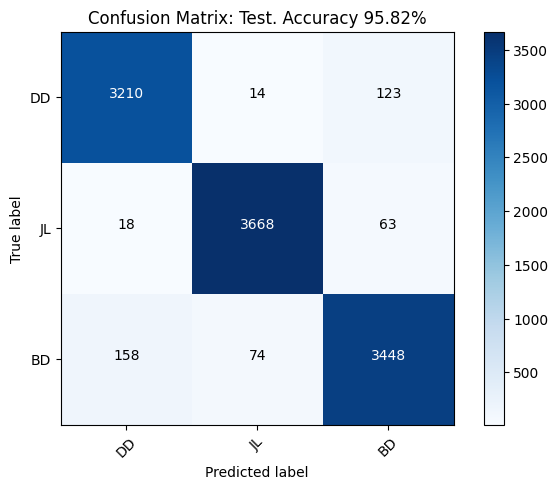

In [115]:
test_predictions_normalization_RX1 = MLP_model_normalozation_RX1.predict(
      x=test_data_normalization_RX1, 
    batch_size=1,
    verbose=2
)

# Rounding predictions values to map into confusion matrix
rounded_predictions_normalization_RX1 = np.argmax(test_predictions_normalization_RX1, axis=-1)

cm_plot_labels = ['DD', 'JL', 'BD']
cm_RX1 = confusion_matrix(y_true=test_label_normalization_RX1, y_pred=rounded_predictions_normalization_RX1)
accuracy_RX1 = accuracy_score(test_label_normalization_RX1, rounded_predictions_normalization_RX1) * 100
plot_confusion_matrix(cm=cm_RX1, classes=cm_plot_labels, 
                      # title=f'Confusion Matrix Test'
                      title=f'Confusion Matrix: Test. Accuracy {accuracy_RX1:.02f}%'
                      )
print("Per class: ", cm_RX1.diagonal()/cm_RX1.sum(axis=1))


# Mencetak classification report
report_RX1 = classification_report(test_label_normalization_RX1, rounded_predictions_normalization_RX1, target_names=cm_plot_labels)
print(report_RX1)

8510/8510 - 34s - 4ms/step
Confusion matrix, without normalization
[[2418  200   27]
 [ 209 2240  109]
 [  25   86 3196]]
Per class:  [0.91417769 0.87568413 0.96643484]
              precision    recall  f1-score   support

          DD       0.91      0.91      0.91      2645
          JL       0.89      0.88      0.88      2558
          BD       0.96      0.97      0.96      3307

    accuracy                           0.92      8510
   macro avg       0.92      0.92      0.92      8510
weighted avg       0.92      0.92      0.92      8510



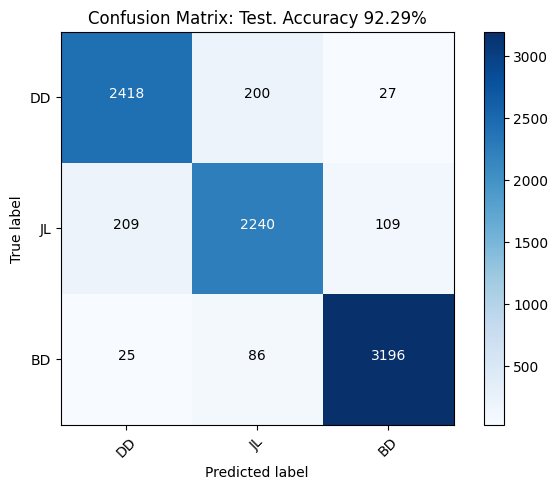

In [116]:
test_predictions_normalization_RX2 = MLP_model_normalization_RX2.predict(
      x=test_data_normalization_RX2,   
    batch_size=1,
    verbose=2
)

# Rounding predictions values to map into confusion matrix
rounded_predictions_normalization_RX2 = np.argmax(test_predictions_normalization_RX2, axis=-1)

cm_plot_labels = ['DD', 'JL', 'BD']
cm_RX2 = confusion_matrix(y_true=test_label_normalization_RX2, y_pred=rounded_predictions_normalization_RX2)
accuracy_RX2 = accuracy_score(test_label_normalization_RX2, rounded_predictions_normalization_RX2) * 100
plot_confusion_matrix(cm=cm_RX2, classes=cm_plot_labels, 
                      # title=f'Confusion Matrix Test'
                      title=f'Confusion Matrix: Test. Accuracy {accuracy_RX2:.02f}%'
                      )
print("Per class: ", cm_RX2.diagonal()/cm_RX2.sum(axis=1))


# Mencetak classification report
report_RX2 = classification_report(test_label_normalization_RX2, rounded_predictions_normalization_RX2, target_names=cm_plot_labels)
print(report_RX2)

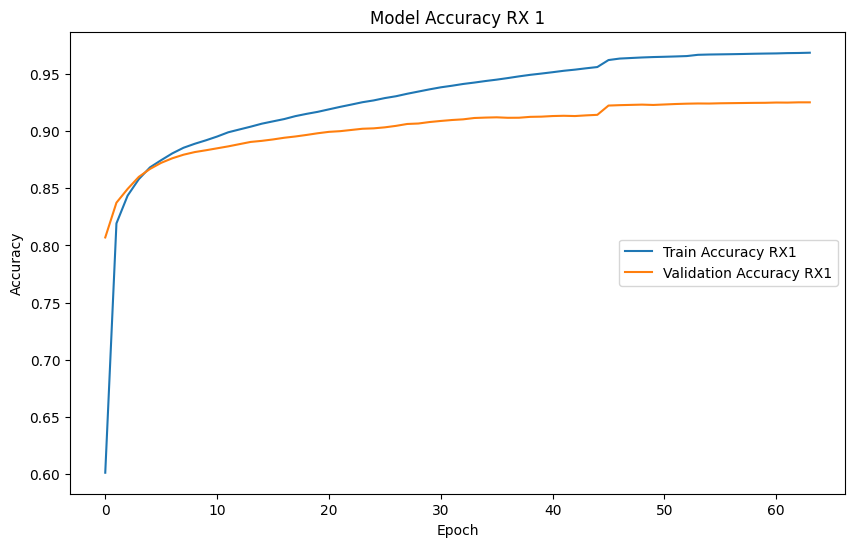

In [117]:
# Untuk plot history
train_accuracy_RX1 = MLP_Robust_History.history['accuracy'] # Biasanya 'accuracy' bukan 'loss' untuk plot akurasi
val_accuracy_RX1 = MLP_Robust_History.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_accuracy_RX1, label='Train Accuracy RX1')
plt.plot(val_accuracy_RX1, label='Validation Accuracy RX1') # Ganti label 'test' menjadi 'validation'
plt.title('Model Accuracy RX 1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='center right') # Sesuaikan lokasi legenda jika perlu
plt.show() # Tambahkan plt.show() untuk menampilkan plot

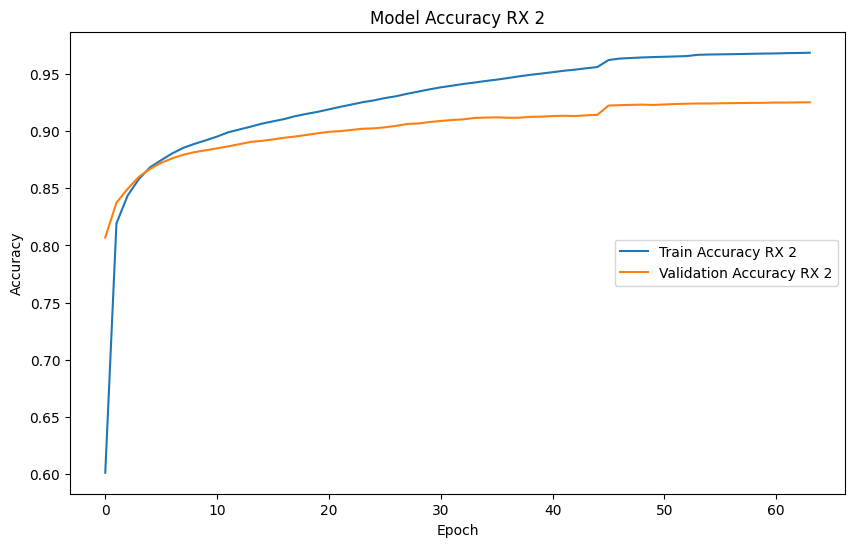

In [118]:
# Untuk plot history
train_accuracy_RX2 = MLP_Robust_History.history['accuracy'] # Biasanya 'accuracy' bukan 'loss' untuk plot akurasi
val_accuracy_RX2 = MLP_Robust_History.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_accuracy_RX2, label='Train Accuracy RX 2')
plt.plot(val_accuracy_RX2, label='Validation Accuracy RX 2') # Ganti label 'test' menjadi 'validation'
plt.title('Model Accuracy RX 2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='center right') # Sesuaikan lokasi legenda jika perlu
plt.show() # Tambahkan plt.show() untuk menampilkan plot

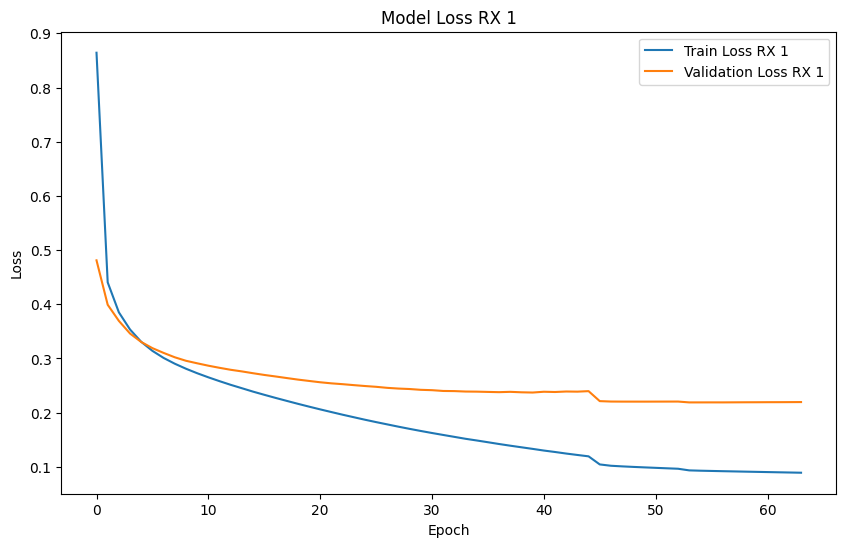

In [119]:
train_loss_RX1 = MLP_Robust_History.history['loss']
val_loss_RX1 = MLP_Robust_History.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss_RX1, label='Train Loss RX 1')
plt.plot(val_loss_RX1, label='Validation Loss RX 1') # Ganti label 'test' menjadi 'validation'
plt.title('Model Loss RX 1')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right') # Sesuaikan lokasi legenda jika perlu
plt.show() # Tambahkan plt.show() untuk menampilkan plot

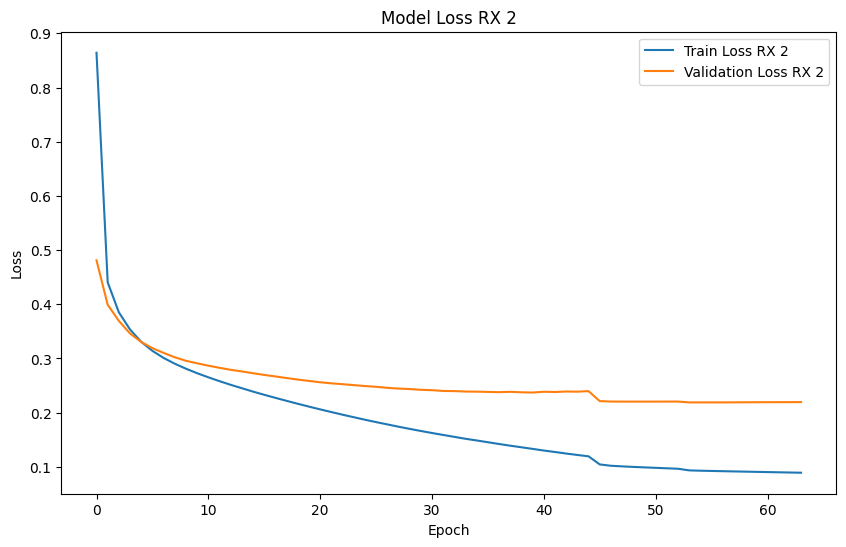

In [120]:
train_loss_RX2 = MLP_Robust_History.history['loss']
val_loss_RX2 = MLP_Robust_History.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss_RX2, label='Train Loss RX 2')
plt.plot(val_loss_RX2, label='Validation Loss RX 2') # Ganti label 'test' menjadi 'validation'
plt.title('Model Loss RX 2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right') # Sesuaikan lokasi legenda jika perlu
plt.show() # Tambahkan plt.show() untuk menampilkan plot